In [1]:
import sys
#sys.path.append('/home/andrea/Dropbox/CIMAT/TESIS/lstmsss/keypoints/partes')
sys.path.append('../keypoints/partes')
import numpy as np
#from process_file import process_file_modif
#from process_file import process_file_modif_varios
from process_file import datos_subprocesados_varios
import batches_data
import model

import tensorflow as tf 
tf.reset_default_graph()

import entrenamientoevaluacion
from entrenamientoevaluacion import evaluate
from interaccion_no_normalizada import batch_vecinos

In [2]:
class parameters:
    def __init__(self):
        self.obs_len = 8
        self.pred_len = 12
        self.add_social = False
        self.kp_num = 18
        self.add_kp = False
        #self.directory_flujo='/home/andrea/Dropbox/CIMAT/TESIS/lstmsss/keypoints'
        self.directory_flujo='../keypoints'

In [3]:
# Cargamos los argumentos
arguments = parameters()

# List of data directories where raw data resides
datasets_entrena_vali = [1,2,3,4]
datasets_prueba = [0]

data_entrena_vali = datos_subprocesados_varios(datasets_entrena_vali, arguments, ',')
data_prueba = datos_subprocesados_varios(datasets_prueba, arguments, ',')
#data_ucyuniv = process_file_modif_varios(ucyuniv_pix_path, arguments, ',')

../data1/eth/hotel/mundo/mun_pos.csv
913
../data1/ucy/zara/zara01/mundo/mun_pos.csv
2356
../data1/ucy/zara/zara02/mundo/mun_pos.csv
5910
../data1/ucy/univ/mundo/mun_pos.csv
10039
(19218, 8, 64)
../data1/eth/univ/mundo/mun_pos.csv
339
(339, 8, 64)


# Dividimos los datos

In [4]:
#se fija la semilaa
import random
random.seed(0)

# Muestreamos aleatoriamente para separar datos de entrenamiento, validacion y prueba
prob = 0.92
# La cantidad total de listas de tam 8 
ndata = len(data_entrena_vali[list(data_entrena_vali.keys())[2]])
idx = random.sample(range(ndata), ndata)
long1 = int(ndata*prob)
long2 = int(ndata-long1)


idx_train = idx[0:long1]
idx_val = idx[long1:]


# conjunto de entrenamiento
data1 = {
     "obs_traj": data_entrena_vali["obs_traj"][idx_train],
     "obs_traj_rel": data_entrena_vali["obs_traj_rel"][idx_train],
    
     "pred_traj": data_entrena_vali["pred_traj"][idx_train],
     "pred_traj_rel": data_entrena_vali["pred_traj_rel"][idx_train],
    
     "key_idx": data_entrena_vali["key_idx"][[idx_train]],
     "obs_flujo" : data_entrena_vali["obs_flujo"][idx_train],
     #"pred_kp": data_pets["pred_kp"][idx_train],
     #"obs_person": data_pets["obs_person"][idx_train],
}


# conjunto de validacion
data3 ={
     "obs_traj": data_entrena_vali["obs_traj"][idx_val],
     "obs_traj_rel": data_entrena_vali["obs_traj_rel"][idx_val],
     "pred_traj": data_entrena_vali["pred_traj"][idx_val],
     "pred_traj_rel": data_entrena_vali["pred_traj_rel"][idx_val],
     "key_idx": data_entrena_vali["key_idx"][[idx_val]],
     "obs_flujo" : data_entrena_vali["obs_flujo"][idx_val],
}


#if arguments.add_kp:
#  print(data3['obs_person_rel'])

print("data_train: "+ str(len(data1[list(data1.keys())[0]])))
print("data_test: "+ str(len(data_prueba[list(data_prueba .keys())[0]])))
print("data_val: "+ str(len(data3[list(data3.keys())[0]])))
#print("data4: "+ str(len(data4[list(data4.keys())[0]])))


data_train: 17680
data_test: 339
data_val: 1538


/home/andrea/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:26: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
/home/andrea/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:39: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


# Guardamos la division de los datos

In [6]:
import pickle

#conjunto de entrenamiento
pickle_out = open("data1_ETHUNIV_12.pickle","wb")
pickle.dump(data1, pickle_out, protocol=2)
pickle_out.close()

#conjunto de prueba
pickle_out = open("data2_ETHUNIV_12.pickle","wb")
pickle.dump(data_prueba, pickle_out, protocol=2)
pickle_out.close()

#conjunto de validacion
pickle_out = open("data3_ETHUNIV_12.pickle","wb")
pickle.dump(data3, pickle_out, protocol=2)
pickle_out.close()

# Parametros para entrenar el modelo

In [7]:
class parameters1:
    def __init__(self, add_kp = None, add_social=None, train_num_examples=None):
        # -----------------
        # Similar a como se procesaron los datos
        self.obs_len = 8
        self.pred_len = 12
        if add_kp is None:
            print('Parameter add kpp missing')
            return
        if train_num_examples is None:
            print('El parametro train_examples fue olvidado')
            return
        if add_social is None:
            print('Parameter add social missing')
            return
        
        self.add_kp = add_kp
        self.train_num_examples = train_num_examples
        self.add_social = add_social
        
        self.kp_num = 18
        self.kp_size = 18
        #self.maxNumPed = 8
        #self.grid_size = 4
        #self.neighborhood_size = 32
        #self.dimensions = [768,576]
        #self.limites=[-15.88,11.56,-19.09,5.99]
        #self.bound=[0.7,0.5]
        # ------------------
        self.num_epochs = 100
        self.batch_size = 20 # batch size
        self.validate = 300
        self.P = 2 # dimensión
        self.enc_hidden_size = 128 # el nombre lo dice
        self.dec_hidden_size = 128
        self.emb_size = 64
        self.keep_prob = 0.7 # dropout
        
        self.min_ped = 1
        self.seq_len = self.obs_len + self.pred_len
        self.reverse_xy = False
        
        self.activation_func = tf.nn.tanh
        self.activation_func1 = tf.nn.relu
        self.is_train = True
        self.is_test = False
        self.multi_decoder = False
        self.modelname = 'gphuctl'
        
        self.init_lr = 0.002 # 0.01
        self.learning_rate_decay = 0.85
        self.num_epoch_per_decay = 2.0
        self.optimizer = 'adam'
        self.emb_lr = 1.0
        #self.clip_gradient_norm = 10.0
        #Para cuando entreno y quiero guardar el mejor modelo
        self.load_best = True

# Entrenamos el modelo

In [8]:
import os 
from tqdm import tqdm
import tensorflow as tf
import math

tf.reset_default_graph()

arguments = parameters1(add_kp = False, add_social = True,train_num_examples=len(data1['obs_traj']))
model = model.Model(arguments)

train_data = batches_data.Dataset(data1,arguments)
val_data = batches_data.Dataset(data3,arguments)

saver = tf.train.Saver(max_to_keep = 2)
bestsaver = tf.train.Saver(max_to_keep = 2)


trainer = entrenamientoevaluacion.Trainer(model,arguments)
tester = entrenamientoevaluacion.Tester(model, arguments)

#inicializamos las variables globales
init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)

increment_global_step_op = tf.assign(model.global_step, model.global_step+1)

val_perf = []
loss = -1
metric = 'ade'

best = {metric:999999, 'fde':0, 'step':-1}
is_start = True

num_steps = int(math.ceil(train_data.num_examples/float(arguments.batch_size)))
loss_list = []
print(num_steps)

for i in range(arguments.num_epochs):
    print('Epoca {0}.' .format(i+1), 'lr:', sess.run(trainer.get_lr()))
    
    #For de batches
    for idx, batch in tqdm(train_data.get_batches(arguments.batch_size,num_steps = num_steps),total=num_steps):
        
        sess.run(increment_global_step_op)
        global_step = sess.run(model.global_step)

        #Evaluamos el entrenamiento
        if((global_step%arguments.validate==0) or (arguments.load_best and is_start)):
            tqdm.write("\tsaving model %s..." % global_step)
            checkpoint_path_model = os.path.join('SINKP_NON_ETHUNIV_12', 'model.ckpt')
            saver.save(sess,checkpoint_path_model , global_step = global_step)
            tqdm.write("\tdone")
            
            print('Evaluating')
            results = evaluate(val_data, tester,sess,arguments)
            print(results)
           
            tqdm.write(("\t last loss:%.9f, eval on validation:%s,"
                    " (best %s:%s at step %s) ") % (loss,["%s: %s" % (k, results[k]) for k in sorted(results.keys())], metric,best[metric], best["step"]))
            if results["ade"]< best[metric]:
                best[metric] = results["ade"]
                best["fde"] =results["fde"]
                best["step"] = global_step
                
                tqdm.write("\t saving best model...")
                checkpoint_path_model_best = os.path.join('SINKP_NON_ETHUNIV-BEST_12', 'model_best.ckpt')
                bestsaver.save(sess,checkpoint_path_model_best,global_step = global_step)
                tqdm.write("\t done.")
                finalperf = results
                val_perf.append((loss, results))
            is_start = False
        loss, train_op = trainer.step(sess, batch)
        loss_list.append(loss)
    
if((global_step % arguments.validate)!=0):
  checkpoint_path_model = os.path.join('SINKP_NON_ETHUNIV_12', 'model.ckpt')
  saver.save(sess,checkpoint_path_model , global_step = global_step)

print("best eval on val %s: %s at %s step y fde es %s " % (metric, best[metric], best["step"],best["fde"]))


W0102 09:49:11.542941 140686521648896 deprecation_wrapper.py:119] From /home/andrea/Dropbox/CIMAT/TESIS/lstmsss/keypoints/partes/model.py:13: The name tf.get_variable is deprecated. Please use tf.compat.v1.get_variable instead.

W0102 09:49:11.559890 140686521648896 deprecation_wrapper.py:119] From /home/andrea/Dropbox/CIMAT/TESIS/lstmsss/keypoints/partes/model.py:31: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0102 09:49:11.583153 140686521648896 deprecation.py:323] From /home/andrea/Dropbox/CIMAT/TESIS/lstmsss/keypoints/partes/model.py:70: __init__ (from tensorflow.python.ops.rnn_cell_impl) is deprecated and will be removed in a future version.
Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
W0102 09:49:11.585311 140686521648896 deprecation_wrapper.py:119] From /home/andrea/Dropbox/CIMAT/TESIS/lstmsss/keypoints/partes/model.py:72: The name tf.nn.rnn_cell.DropoutW

884
('Epoca 1.', 'lr:', 0.002)
	saving model 1...



  0%|          | 0/77 [00:00<?, ?it/s]

	done
Evaluating



100%|##########| 77/77 [00:01<00:00, 55.61it/s]

{'ade': 1.6696161, 'fde': 3.0567772}
	 last loss:-1.000000000, eval on validation:['ade: 1.6696161', 'fde: 3.0567772'], (best ade:999999 at step -1) 
	 saving best model...
	 done.


  0%|          | 0/77 [00:00<?, ?it/s]

	saving model 300...
	done
Evaluating



100%|##########| 77/77 [00:00<00:00, 84.23it/s]

{'ade': 0.48579118, 'fde': 1.0569777}
	 last loss:0.000806828, eval on validation:['ade: 0.48579118', 'fde: 1.0569777'], (best ade:1.6696161 at step 1) 
	 saving best model...
	 done.


 68%|██████▊   | 598/884 [00:27<00:11, 25.87it/s]W0102 09:49:42.892008 140686521648896 deprecation.py:323] From /home/andrea/anaconda2/lib/python2.7/site-packages/tensorflow/python/training/saver.py:960: remove_checkpoint (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use standard file APIs to delete files with this prefix.

  0%|          | 0/77 [00:00<?, ?it/s]

	saving model 600...
	done
Evaluating



 68%|██████▊   | 601/884 [00:28<00:41,  6.76it/s]A

{'ade': 0.5066943, 'fde': 1.1048833}
	 last loss:0.000610547, eval on validation:['ade: 0.5066943', 'fde: 1.1048833'], (best ade:0.48579118 at step 300) 


  0%|          | 1/884 [00:00<01:43,  8.56it/s]

('Epoca 2.', 'lr:', 0.002)


  0%|          | 0/77 [00:00<?, ?it/s]

	saving model 900...
	done
Evaluating



  2%|▏         | 19/884 [00:01<01:45,  8.18it/s][A

{'ade': 0.5054731, 'fde': 1.101157}
	 last loss:0.000586671, eval on validation:['ade: 0.5054731', 'fde: 1.101157'], (best ade:0.48579118 at step 300) 


  0%|          | 0/77 [00:00<?, ?it/s]

	saving model 1200...
	done
Evaluating



 36%|███▌      | 319/884 [00:14<01:03,  8.93it/s]A

{'ade': 0.5322996, 'fde': 1.1653365}
	 last loss:0.000689792, eval on validation:['ade: 0.5322996', 'fde: 1.1653365'], (best ade:0.48579118 at step 300) 


  0%|          | 0/77 [00:00<?, ?it/s]

	saving model 1500...
	done
Evaluating



 70%|███████   | 619/884 [00:27<00:32,  8.25it/s]A

{'ade': 0.60867876, 'fde': 1.394625}
	 last loss:0.000707436, eval on validation:['ade: 0.60867876', 'fde: 1.394625'], (best ade:0.48579118 at step 300) 


  0%|          | 1/884 [00:00<01:49,  8.04it/s]

('Epoca 3.', 'lr:', 0.0017000001)


  4%|▎         | 31/884 [00:01<00:36, 23.27it/s]

	saving model 1800...



 12%|#1        | 9/77 [00:00<00:00, 82.21it/s]

	done
Evaluating



  4%|▍         | 34/884 [00:02<02:14,  6.30it/s][A

{'ade': 0.51651615, 'fde': 1.1279811}
	 last loss:0.000317692, eval on validation:['ade: 0.51651615', 'fde: 1.1279811'], (best ade:0.48579118 at step 300) 


 37%|███▋      | 331/884 [00:14<00:22, 24.75it/s]

	saving model 2100...



 38%|███▊      | 334/884 [00:16<01:27,  6.28it/s]A

	done
Evaluating
{'ade': 0.59339064, 'fde': 1.3430009}
	 last loss:0.000768154, eval on validation:['ade: 0.59339064', 'fde: 1.3430009'], (best ade:0.48579118 at step 300) 


 71%|███████▏  | 631/884 [00:28<00:10, 24.77it/s]


	saving model 2400...
	done
Evaluating


 72%|███████▏  | 634/884 [00:29<00:39,  6.37it/s]A

{'ade': 0.5472664, 'fde': 1.212549}
	 last loss:0.000617550, eval on validation:['ade: 0.5472664', 'fde: 1.212549'], (best ade:0.48579118 at step 300) 


  0%|          | 2/884 [00:00<00:59, 14.78it/s]

('Epoca 4.', 'lr:', 0.0017000001)


  5%|▌         | 47/884 [00:01<00:34, 24.61it/s]


	saving model 2700...
	done
Evaluating


  6%|▌         | 50/884 [00:03<02:10,  6.40it/s][A

{'ade': 0.49924737, 'fde': 1.1024112}
	 last loss:0.000398219, eval on validation:['ade: 0.49924737', 'fde: 1.1024112'], (best ade:0.48579118 at step 300) 


 39%|███▉      | 347/884 [00:15<00:21, 24.51it/s]


	saving model 3000...
	done
Evaluating


 40%|███▉      | 350/884 [00:16<01:23,  6.36it/s]A

{'ade': 0.56679463, 'fde': 1.2885103}
	 last loss:0.000606211, eval on validation:['ade: 0.56679463', 'fde: 1.2885103'], (best ade:0.48579118 at step 300) 


 73%|███████▎  | 647/884 [00:28<00:09, 24.43it/s]


	saving model 3300...
	done
Evaluating


 74%|███████▎  | 650/884 [00:30<00:36,  6.38it/s]A

{'ade': 0.5103599, 'fde': 1.1402415}
	 last loss:0.000482720, eval on validation:['ade: 0.5103599', 'fde: 1.1402415'], (best ade:0.48579118 at step 300) 


  0%|          | 2/884 [00:00<00:57, 15.43it/s]

('Epoca 5.', 'lr:', 0.0014450002)


  0%|          | 0/77 [00:00<?, ?it/s]

	saving model 3600...
	done
Evaluating



  7%|▋         | 65/884 [00:03<02:07,  6.43it/s][A

{'ade': 0.51480937, 'fde': 1.1416329}
	 last loss:0.000707213, eval on validation:['ade: 0.51480937', 'fde: 1.1416329'], (best ade:0.48579118 at step 300) 


  0%|          | 0/77 [00:00<?, ?it/s]

	saving model 3900...
	done
Evaluating



 41%|████▏     | 365/884 [00:17<01:20,  6.42it/s]A

{'ade': 0.49225014, 'fde': 1.086638}
	 last loss:0.000429070, eval on validation:['ade: 0.49225014', 'fde: 1.086638'], (best ade:0.48579118 at step 300) 


  0%|          | 0/77 [00:00<?, ?it/s]

	saving model 4200...
	done
Evaluating



 75%|███████▌  | 665/884 [00:30<00:36,  5.95it/s]A

{'ade': 0.5180951, 'fde': 1.145458}
	 last loss:0.000342019, eval on validation:['ade: 0.5180951', 'fde: 1.145458'], (best ade:0.48579118 at step 300) 


  0%|          | 3/884 [00:00<00:37, 23.49it/s]

('Epoca 6.', 'lr:', 0.0014450002)


  0%|          | 0/77 [00:00<?, ?it/s]

	saving model 4500...
	done
Evaluating



  9%|▉         | 81/884 [00:04<02:06,  6.33it/s][A

{'ade': 0.53983283, 'fde': 1.217859}
	 last loss:0.000408222, eval on validation:['ade: 0.53983283', 'fde: 1.217859'], (best ade:0.48579118 at step 300) 


  0%|          | 0/77 [00:00<?, ?it/s]

	saving model 4800...
	done
Evaluating



 43%|████▎     | 381/884 [00:17<01:18,  6.39it/s]A

{'ade': 0.5278189, 'fde': 1.1841002}
	 last loss:0.000592461, eval on validation:['ade: 0.5278189', 'fde: 1.1841002'], (best ade:0.48579118 at step 300) 


  0%|          | 0/77 [00:00<?, ?it/s]

	saving model 5100...
	done
Evaluating



 77%|███████▋  | 681/884 [00:31<00:31,  6.39it/s]A

{'ade': 0.50260425, 'fde': 1.1031796}
	 last loss:0.000397502, eval on validation:['ade: 0.50260425', 'fde: 1.1031796'], (best ade:0.48579118 at step 300) 


  0%|          | 1/884 [00:00<01:39,  8.90it/s]

('Epoca 7.', 'lr:', 0.0012282502)


  0%|          | 0/77 [00:00<?, ?it/s]

	saving model 5400...
	done
Evaluating



 11%|█         | 97/884 [00:05<02:02,  6.41it/s][A

{'ade': 0.5207275, 'fde': 1.1498692}
	 last loss:0.000260093, eval on validation:['ade: 0.5207275', 'fde: 1.1498692'], (best ade:0.48579118 at step 300) 


  0%|          | 0/77 [00:00<?, ?it/s]

	saving model 5700...
	done
Evaluating



 45%|████▍     | 397/884 [00:18<01:16,  6.39it/s]A

{'ade': 0.4972658, 'fde': 1.0962486}
	 last loss:0.000447781, eval on validation:['ade: 0.4972658', 'fde: 1.0962486'], (best ade:0.48579118 at step 300) 


  0%|          | 0/77 [00:00<?, ?it/s]

	saving model 6000...
	done
Evaluating



 79%|███████▉  | 697/884 [00:31<00:29,  6.39it/s]A

{'ade': 0.5244619, 'fde': 1.1776965}
	 last loss:0.000498720, eval on validation:['ade: 0.5244619', 'fde: 1.1776965'], (best ade:0.48579118 at step 300) 


  0%|          | 2/884 [00:00<01:00, 14.66it/s]

('Epoca 8.', 'lr:', 0.0012282502)


  0%|          | 0/77 [00:00<?, ?it/s]

	saving model 6300...
	done
Evaluating



 13%|█▎        | 113/884 [00:05<02:00,  6.42it/s]A

{'ade': 0.5546899, 'fde': 1.2531127}
	 last loss:0.000316215, eval on validation:['ade: 0.5546899', 'fde: 1.2531127'], (best ade:0.48579118 at step 300) 


  0%|          | 0/77 [00:00<?, ?it/s]

	saving model 6600...
	done
Evaluating



 47%|████▋     | 413/884 [00:19<01:13,  6.41it/s]A

{'ade': 0.5464676, 'fde': 1.2292017}
	 last loss:0.000744436, eval on validation:['ade: 0.5464676', 'fde: 1.2292017'], (best ade:0.48579118 at step 300) 


 80%|████████  | 711/884 [00:34<00:07, 23.59it/s]

	saving model 6900...



  8%|7         | 6/77 [00:00<00:01, 59.92it/s]

	done
Evaluating



 81%|████████  | 714/884 [00:35<00:30,  5.56it/s]A

{'ade': 0.5076602, 'fde': 1.1316621}
	 last loss:0.000406894, eval on validation:['ade: 0.5076602', 'fde: 1.1316621'], (best ade:0.48579118 at step 300) 


  0%|          | 1/884 [00:00<01:45,  8.38it/s]

('Epoca 9.', 'lr:', 0.0010440127)


 14%|█▍        | 127/884 [00:05<00:30, 24.47it/s]

	saving model 7200...
	done
Evaluating



 15%|█▍        | 130/884 [00:06<02:12,  5.68it/s]A

{'ade': 0.53755987, 'fde': 1.2040622}
	 last loss:0.000567062, eval on validation:['ade: 0.53755987', 'fde: 1.2040622'], (best ade:0.48579118 at step 300) 


 48%|████▊     | 426/884 [00:18<00:18, 25.03it/s]

	saving model 7500...



 10%|#         | 8/77 [00:00<00:00, 75.74it/s]

	done
Evaluating



100%|##########| 77/77 [00:01<00:00, 74.05it/s]

{'ade': 0.4795495, 'fde': 1.0556648}
	 last loss:0.000921417, eval on validation:['ade: 0.4795495', 'fde: 1.0556648'], (best ade:0.48579118 at step 300) 
	 saving best model...


  0%|          | 0/77 [00:00<?, ?it/s]

	 done.
	saving model 7800...
	done
Evaluating



 83%|████████▎ | 732/884 [00:34<00:19,  7.83it/s]A

{'ade': 0.49240375, 'fde': 1.0760456}
	 last loss:0.000504760, eval on validation:['ade: 0.49240375', 'fde: 1.0760456'], (best ade:0.4795495 at step 7500) 


  0%|          | 2/884 [00:00<00:44, 19.90it/s]

('Epoca 10.', 'lr:', 0.0010440127)


 16%|█▌        | 143/884 [00:05<00:29, 24.70it/s]

	saving model 8100...



 10%|#         | 8/77 [00:00<00:00, 77.59it/s]

	done
Evaluating



 17%|█▋        | 146/884 [00:07<02:03,  6.00it/s]A

{'ade': 0.50854075, 'fde': 1.134306}
	 last loss:0.000285491, eval on validation:['ade: 0.50854075', 'fde: 1.134306'], (best ade:0.4795495 at step 7500) 


  0%|          | 0/77 [00:00<?, ?it/s]

	saving model 8400...
	done
Evaluating



100%|##########| 77/77 [00:01<00:00, 73.99it/s]

{'ade': 0.47670674, 'fde': 1.0362352}
	 last loss:0.000304431, eval on validation:['ade: 0.47670674', 'fde: 1.0362352'], (best ade:0.4795495 at step 7500) 
	 saving best model...


  0%|          | 0/77 [00:00<?, ?it/s]

	 done.
	saving model 8700...
	done
Evaluating



 84%|████████▍ | 746/884 [00:34<00:22,  6.10it/s]A

{'ade': 0.4912022, 'fde': 1.0798023}
	 last loss:0.000385159, eval on validation:['ade: 0.4912022', 'fde: 1.0798023'], (best ade:0.47670674 at step 8400) 


  0%|          | 1/884 [00:00<01:35,  9.29it/s]

('Epoca 11.', 'lr:', 0.0008874108)


  0%|          | 0/77 [00:00<?, ?it/s]

	saving model 9000...
	done
Evaluating



 18%|█▊        | 163/884 [00:07<01:31,  7.84it/s]A

{'ade': 0.49413756, 'fde': 1.0916158}
	 last loss:0.000476759, eval on validation:['ade: 0.49413756', 'fde: 1.0916158'], (best ade:0.47670674 at step 8400) 


  0%|          | 0/77 [00:00<?, ?it/s]

	saving model 9300...
	done
Evaluating



100%|##########| 77/77 [00:01<00:00, 74.14it/s]

{'ade': 0.47451827, 'fde': 1.0434364}
	 last loss:0.000528533, eval on validation:['ade: 0.47451827', 'fde: 1.0434364'], (best ade:0.47670674 at step 8400) 
	 saving best model...


 52%|█████▏    | 463/884 [00:21<01:00,  6.96it/s]

	 done.


  0%|          | 0/77 [00:00<?, ?it/s]

	saving model 9600...
	done
Evaluating



 86%|████████▋ | 764/884 [00:35<00:15,  7.82it/s]A

{'ade': 0.49864605, 'fde': 1.1000322}
	 last loss:0.000677336, eval on validation:['ade: 0.49864605', 'fde: 1.1000322'], (best ade:0.47451827 at step 9300) 


  0%|          | 3/884 [00:00<00:36, 24.19it/s]

('Epoca 12.', 'lr:', 0.0008874108)


  0%|          | 0/77 [00:00<?, ?it/s]

	saving model 9900...
	done
Evaluating



 20%|██        | 179/884 [00:08<01:30,  7.81it/s]A

{'ade': 0.5698056, 'fde': 1.2939136}
	 last loss:0.000340286, eval on validation:['ade: 0.5698056', 'fde: 1.2939136'], (best ade:0.47451827 at step 9300) 


  0%|          | 0/77 [00:00<?, ?it/s]

	saving model 10200...
	done
Evaluating



 54%|█████▍    | 479/884 [00:22<00:51,  7.88it/s]A

{'ade': 0.48217508, 'fde': 1.0665255}
	 last loss:0.000442375, eval on validation:['ade: 0.48217508', 'fde: 1.0665255'], (best ade:0.47451827 at step 9300) 


  0%|          | 0/77 [00:00<?, ?it/s]

	saving model 10500...
	done
Evaluating



 88%|████████▊ | 779/884 [00:36<00:13,  7.79it/s]A

{'ade': 0.5098707, 'fde': 1.1433071}
	 last loss:0.000401025, eval on validation:['ade: 0.5098707', 'fde: 1.1433071'], (best ade:0.47451827 at step 9300) 


  0%|          | 1/884 [00:00<01:39,  8.85it/s]

('Epoca 13.', 'lr:', 0.0007542992)


  0%|          | 0/77 [00:00<?, ?it/s]

	saving model 10800...
	done
Evaluating



 22%|██▏       | 195/884 [00:09<01:27,  7.83it/s]A

{'ade': 0.51548696, 'fde': 1.154768}
	 last loss:0.000257564, eval on validation:['ade: 0.51548696', 'fde: 1.154768'], (best ade:0.47451827 at step 9300) 


  0%|          | 0/77 [00:00<?, ?it/s]

	saving model 11100...
	done
Evaluating



 56%|█████▌    | 494/884 [00:22<00:51,  7.53it/s]A

{'ade': 0.5041048, 'fde': 1.1247473}
	 last loss:0.000514684, eval on validation:['ade: 0.5041048', 'fde: 1.1247473'], (best ade:0.47451827 at step 9300) 


  0%|          | 0/77 [00:00<?, ?it/s]

	saving model 11400...
	done
Evaluating



 90%|█████████ | 796/884 [00:36<00:11,  7.76it/s]A

{'ade': 0.5028168, 'fde': 1.1306446}
	 last loss:0.000545434, eval on validation:['ade: 0.5028168', 'fde: 1.1306446'], (best ade:0.47451827 at step 9300) 


  0%|          | 1/884 [00:00<01:35,  9.24it/s]

('Epoca 14.', 'lr:', 0.0007542992)


 23%|██▎       | 205/884 [00:08<00:27, 25.02it/s]

	saving model 11700...



 10%|#         | 8/77 [00:00<00:00, 75.10it/s]

	done
Evaluating



100%|##########| 77/77 [00:01<00:00, 73.86it/s]

{'ade': 0.47366706, 'fde': 1.037637}
	 last loss:0.000477013, eval on validation:['ade: 0.47366706', 'fde: 1.037637'], (best ade:0.47451827 at step 9300) 
	 saving best model...
	 done.


 57%|█████▋    | 507/884 [00:22<00:15, 24.82it/s]


	saving model 12000...
	done
Evaluating


 58%|█████▊    | 510/884 [00:23<01:01,  6.04it/s]A

{'ade': 0.4876864, 'fde': 1.0719988}
	 last loss:0.000338052, eval on validation:['ade: 0.4876864', 'fde: 1.0719988'], (best ade:0.47366706 at step 11700) 


  0%|          | 0/77 [00:00<?, ?it/s]

	saving model 12300...
	done
Evaluating



100%|##########| 77/77 [00:01<00:00, 73.57it/s]

{'ade': 0.46725863, 'fde': 1.0165045}
	 last loss:0.000444798, eval on validation:['ade: 0.46725863', 'fde: 1.0165045'], (best ade:0.47366706 at step 11700) 
	 saving best model...
	 done.

 92%|█████████▏| 811/884 [00:37<00:10,  7.01it/s]

  0%|          | 1/884 [00:00<01:41,  8.66it/s]

('Epoca 15.', 'lr:', 0.0006411543)


  0%|          | 0/77 [00:00<?, ?it/s]

	saving model 12600...
	done
Evaluating



 26%|██▌       | 227/884 [00:10<01:22,  7.93it/s]A

{'ade': 0.49477917, 'fde': 1.0996888}
	 last loss:0.000404570, eval on validation:['ade: 0.49477917', 'fde: 1.0996888'], (best ade:0.46725863 at step 12300) 


 59%|█████▉    | 521/884 [00:22<00:14, 25.08it/s]

	saving model 12900...
	done


 10%|#         | 8/77 [00:00<00:00, 69.90it/s]


Evaluating



 60%|█████▉    | 527/884 [00:24<00:46,  7.74it/s]A

{'ade': 0.4715719, 'fde': 1.0338172}
	 last loss:0.000445963, eval on validation:['ade: 0.4715719', 'fde: 1.0338172'], (best ade:0.46725863 at step 12300) 


 93%|█████████▎| 821/884 [00:36<00:02, 25.11it/s]


	saving model 13200...
	done
Evaluating


 94%|█████████▎| 827/884 [00:38<00:07,  8.06it/s]A

{'ade': 0.49547288, 'fde': 1.103682}
	 last loss:0.000383058, eval on validation:['ade: 0.49547288', 'fde: 1.103682'], (best ade:0.46725863 at step 12300) 


  0%|          | 1/884 [00:00<01:37,  9.07it/s]

('Epoca 16.', 'lr:', 0.0006411543)


  0%|          | 0/77 [00:00<?, ?it/s]

	saving model 13500...
	done
Evaluating



 27%|██▋       | 243/884 [00:11<01:21,  7.90it/s]A

{'ade': 0.47606078, 'fde': 1.0422249}
	 last loss:0.000311377, eval on validation:['ade: 0.47606078', 'fde: 1.0422249'], (best ade:0.46725863 at step 12300) 


 61%|██████    | 537/884 [00:23<00:13, 25.26it/s]

	saving model 13800...



 12%|#1        | 9/77 [00:00<00:00, 88.50it/s]

	done
Evaluating



 61%|██████▏   | 543/884 [00:24<00:43,  7.80it/s]A

{'ade': 0.48270902, 'fde': 1.065875}
	 last loss:0.000291055, eval on validation:['ade: 0.48270902', 'fde: 1.065875'], (best ade:0.46725863 at step 12300) 


  0%|          | 0/77 [00:00<?, ?it/s]

	saving model 14100...
	done
Evaluating



 95%|█████████▌| 842/884 [00:38<00:05,  7.79it/s]A

{'ade': 0.5011225, 'fde': 1.114006}
	 last loss:0.000264067, eval on validation:['ade: 0.5011225', 'fde: 1.114006'], (best ade:0.46725863 at step 12300) 


  0%|          | 1/884 [00:00<01:30,  9.73it/s]

('Epoca 17.', 'lr:', 0.0005449812)


  0%|          | 0/77 [00:00<?, ?it/s]

	saving model 14400...
	done
Evaluating



 29%|██▉       | 258/884 [00:11<01:44,  5.98it/s]A

{'ade': 0.49474096, 'fde': 1.0977566}
	 last loss:0.000353915, eval on validation:['ade: 0.49474096', 'fde: 1.0977566'], (best ade:0.46725863 at step 12300) 


 63%|██████▎   | 555/884 [00:24<00:16, 20.43it/s]

	saving model 14700...



 10%|#         | 8/77 [00:00<00:00, 73.93it/s]

	done
Evaluating



 63%|██████▎   | 558/884 [00:25<00:56,  5.76it/s]A

{'ade': 0.46852946, 'fde': 1.0243797}
	 last loss:0.000471559, eval on validation:['ade: 0.46852946', 'fde: 1.0243797'], (best ade:0.46725863 at step 12300) 


 97%|█████████▋| 855/884 [00:37<00:01, 22.82it/s]

	saving model 15000...



 10%|#         | 8/77 [00:00<00:00, 78.30it/s]

	done
Evaluating



 97%|█████████▋| 858/884 [00:39<00:04,  5.69it/s]A

{'ade': 0.47035125, 'fde': 1.03038}
	 last loss:0.000509454, eval on validation:['ade: 0.47035125', 'fde: 1.03038'], (best ade:0.46725863 at step 12300) 


  0%|          | 1/884 [00:00<01:35,  9.25it/s]

('Epoca 18.', 'lr:', 0.0005449812)


  0%|          | 0/77 [00:00<?, ?it/s]

	saving model 15300...
	done
Evaluating



 31%|███       | 275/884 [00:12<01:17,  7.81it/s]A

{'ade': 0.47123978, 'fde': 1.0267316}
	 last loss:0.000285133, eval on validation:['ade: 0.47123978', 'fde: 1.0267316'], (best ade:0.46725863 at step 12300) 


  0%|          | 0/77 [00:00<?, ?it/s]

	saving model 15600...
	done
Evaluating



 65%|██████▍   | 572/884 [00:25<00:53,  5.84it/s]A

{'ade': 0.47304717, 'fde': 1.0397456}
	 last loss:0.000439178, eval on validation:['ade: 0.47304717', 'fde: 1.0397456'], (best ade:0.46725863 at step 12300) 


  0%|          | 0/77 [00:00<?, ?it/s]

	saving model 15900...
	done
Evaluating



 99%|█████████▉| 874/884 [00:39<00:01,  6.09it/s]A

{'ade': 0.4684514, 'fde': 1.0282342}
	 last loss:0.000400133, eval on validation:['ade: 0.4684514', 'fde: 1.0282342'], (best ade:0.46725863 at step 12300) 


  0%|          | 2/884 [00:00<00:45, 19.29it/s]

('Epoca 19.', 'lr:', 0.00046323403)


 32%|███▏      | 287/884 [00:11<00:24, 24.67it/s]

	saving model 16200...



 33%|███▎      | 290/884 [00:13<01:38,  6.06it/s]A

	done
Evaluating
{'ade': 0.4787013, 'fde': 1.0583644}
	 last loss:0.000369946, eval on validation:['ade: 0.4787013', 'fde: 1.0583644'], (best ade:0.46725863 at step 12300) 


  0%|          | 0/77 [00:00<?, ?it/s]

	saving model 16500...
	done
Evaluating



100%|##########| 77/77 [00:01<00:00, 73.83it/s]

{'ade': 0.4630198, 'fde': 1.0084163}
	 last loss:0.000340784, eval on validation:['ade: 0.4630198', 'fde: 1.0084163'], (best ade:0.46725863 at step 12300) 
	 saving best model...


 67%|██████▋   | 590/884 [00:26<00:55,  5.30it/s]

	 done.


  0%|          | 2/884 [00:00<00:53, 16.36it/s]

('Epoca 20.', 'lr:', 0.00046323403)
	saving model 16800...



 12%|#1        | 9/77 [00:00<00:00, 86.89it/s]

	done
Evaluating



  1%|          | 7/884 [00:01<02:40,  5.46it/s]

{'ade': 0.4754991, 'fde': 1.0457686}
	 last loss:0.000370707, eval on validation:['ade: 0.4754991', 'fde: 1.0457686'], (best ade:0.4630198 at step 16500) 


 34%|███▍      | 301/884 [00:13<00:23, 24.53it/s]

	saving model 17100...



 12%|#1        | 9/77 [00:00<00:00, 85.92it/s]

	done
Evaluating



 35%|███▍      | 307/884 [00:15<01:12,  8.01it/s]A

{'ade': 0.47292003, 'fde': 1.0415014}
	 last loss:0.000289954, eval on validation:['ade: 0.47292003', 'fde: 1.0415014'], (best ade:0.4630198 at step 16500) 


  0%|          | 0/77 [00:00<?, ?it/s]

	saving model 17400...
	done
Evaluating



 69%|██████▊   | 606/884 [00:28<00:37,  7.44it/s]A

{'ade': 0.4694456, 'fde': 1.0314543}
	 last loss:0.000439688, eval on validation:['ade: 0.4694456', 'fde: 1.0314543'], (best ade:0.4630198 at step 16500) 


  0%|          | 2/884 [00:00<00:45, 19.39it/s]

('Epoca 21.', 'lr:', 0.00039374892)


  0%|          | 0/77 [00:00<?, ?it/s]

	saving model 17700...
	done
Evaluating



  3%|▎         | 23/884 [00:02<02:31,  5.69it/s][A

{'ade': 0.4735729, 'fde': 1.0352151}
	 last loss:0.000343522, eval on validation:['ade: 0.4735729', 'fde: 1.0352151'], (best ade:0.4630198 at step 16500) 


 36%|███▌      | 317/884 [00:14<00:22, 25.21it/s]

	saving model 18000...



 37%|███▋      | 323/884 [00:15<01:09,  8.03it/s]A

	done
Evaluating
{'ade': 0.47528264, 'fde': 1.0508182}
	 last loss:0.000383087, eval on validation:['ade: 0.47528264', 'fde: 1.0508182'], (best ade:0.4630198 at step 16500) 


 70%|███████   | 619/884 [00:28<00:11, 23.62it/s]

	saving model 18300...



 70%|███████   | 622/884 [00:29<00:45,  5.81it/s]A

	done
Evaluating
{'ade': 0.47518164, 'fde': 1.0395974}
	 last loss:0.000431119, eval on validation:['ade: 0.47518164', 'fde: 1.0395974'], (best ade:0.4630198 at step 16500) 


  0%|          | 1/884 [00:00<01:56,  7.59it/s]

('Epoca 22.', 'lr:', 0.00039374892)


  0%|          | 0/77 [00:00<?, ?it/s]

	saving model 18600...
	done
Evaluating



100%|##########| 77/77 [00:01<00:00, 72.06it/s]

{'ade': 0.46027613, 'fde': 1.0051395}
	 last loss:0.000330434, eval on validation:['ade: 0.46027613', 'fde: 1.0051395'], (best ade:0.4630198 at step 16500) 
	 saving best model...


  4%|▍         | 37/884 [00:03<02:41,  5.25it/s]

	 done.


  0%|          | 0/77 [00:00<?, ?it/s]

	saving model 18900...
	done
Evaluating



 38%|███▊      | 340/884 [00:16<01:10,  7.72it/s]A

{'ade': 0.46313667, 'fde': 1.0059277}
	 last loss:0.000468010, eval on validation:['ade: 0.46313667', 'fde: 1.0059277'], (best ade:0.46027613 at step 18600) 


 72%|███████▏  | 634/884 [00:29<00:10, 23.03it/s]

	saving model 19200...



 72%|███████▏  | 639/884 [00:30<00:35,  6.96it/s]A

	done
Evaluating
{'ade': 0.46934327, 'fde': 1.0341505}
	 last loss:0.000374410, eval on validation:['ade: 0.46934327', 'fde: 1.0341505'], (best ade:0.46027613 at step 18600) 


  0%|          | 1/884 [00:00<01:39,  8.87it/s]

('Epoca 23.', 'lr:', 0.0003346866)


  6%|▌         | 50/884 [00:02<00:42, 19.83it/s]

	saving model 19500...



  9%|9         | 7/77 [00:00<00:01, 65.32it/s]

	done
Evaluating



  6%|▌         | 53/884 [00:04<03:09,  4.38it/s][A

{'ade': 0.47272134, 'fde': 1.035356}
	 last loss:0.000325393, eval on validation:['ade: 0.47272134', 'fde: 1.035356'], (best ade:0.46027613 at step 18600) 


 39%|███▉      | 349/884 [00:16<00:22, 24.29it/s]

	saving model 19800...



 10%|#         | 8/77 [00:00<00:00, 78.87it/s]

	done
Evaluating



 40%|████      | 355/884 [00:18<01:09,  7.59it/s]A

{'ade': 0.46575534, 'fde': 1.0189962}
	 last loss:0.000441955, eval on validation:['ade: 0.46575534', 'fde: 1.0189962'], (best ade:0.46027613 at step 18600) 


 74%|███████▎  | 651/884 [00:31<00:09, 24.67it/s]

	saving model 20100...



 12%|#1        | 9/77 [00:00<00:00, 84.73it/s]

	done
Evaluating



100%|##########| 77/77 [00:01<00:00, 75.33it/s]

{'ade': 0.45599473, 'fde': 0.9929628}
	 last loss:0.000483562, eval on validation:['ade: 0.45599473', 'fde: 0.9929628'], (best ade:0.46027613 at step 18600) 
	 saving best model...


  0%|          | 1/884 [00:00<01:47,  8.25it/s]

	 done.
('Epoca 24.', 'lr:', 0.0003346866)


  0%|          | 0/77 [00:00<?, ?it/s]

	saving model 20400...
	done
Evaluating



  8%|▊         | 70/884 [00:04<02:15,  5.99it/s][A

{'ade': 0.4713605, 'fde': 1.0351232}
	 last loss:0.000249364, eval on validation:['ade: 0.4713605', 'fde: 1.0351232'], (best ade:0.45599473 at step 20100) 


  0%|          | 0/77 [00:00<?, ?it/s]

	saving model 20700...
	done
Evaluating



 42%|████▏     | 370/884 [00:17<01:27,  5.89it/s]A

{'ade': 0.47760013, 'fde': 1.0494088}
	 last loss:0.000458067, eval on validation:['ade: 0.47760013', 'fde: 1.0494088'], (best ade:0.45599473 at step 20100) 


 75%|███████▌  | 667/884 [00:30<00:08, 24.62it/s]

	saving model 21000...



 76%|███████▌  | 670/884 [00:31<00:34,  6.21it/s]A

	done
Evaluating
{'ade': 0.4674451, 'fde': 1.0285262}
	 last loss:0.000680143, eval on validation:['ade: 0.4674451', 'fde: 1.0285262'], (best ade:0.45599473 at step 20100) 


  0%|          | 1/884 [00:00<01:53,  7.79it/s]

('Epoca 25.', 'lr:', 0.00028448363)


  0%|          | 0/77 [00:00<?, ?it/s]

	saving model 21300...
	done
Evaluating



 10%|▉         | 88/884 [00:04<01:36,  8.24it/s][A

{'ade': 0.45726958, 'fde': 0.9994317}
	 last loss:0.000175009, eval on validation:['ade: 0.45726958', 'fde: 0.9994317'], (best ade:0.45599473 at step 20100) 


  0%|          | 0/77 [00:00<?, ?it/s]

	saving model 21600...
	done
Evaluating



 44%|████▍     | 388/884 [00:17<00:55,  8.87it/s]A

{'ade': 0.4830871, 'fde': 1.073313}
	 last loss:0.000455449, eval on validation:['ade: 0.4830871', 'fde: 1.073313'], (best ade:0.45599473 at step 20100) 


 77%|███████▋  | 682/884 [00:29<00:08, 24.82it/s]


	saving model 21900...
	done
Evaluating


 77%|███████▋  | 685/884 [00:30<00:32,  6.16it/s]A

{'ade': 0.46691316, 'fde': 1.0119542}
	 last loss:0.000244799, eval on validation:['ade: 0.46691316', 'fde: 1.0119542'], (best ade:0.45599473 at step 20100) 


  0%|          | 1/884 [00:00<01:29,  9.89it/s]

('Epoca 26.', 'lr:', 0.00028448363)


  0%|          | 0/77 [00:00<?, ?it/s]

	saving model 22200...
	done
Evaluating



 12%|█▏        | 103/884 [00:05<01:34,  8.24it/s]A

{'ade': 0.45932657, 'fde': 1.0077399}
	 last loss:0.000387506, eval on validation:['ade: 0.45932657', 'fde: 1.0077399'], (best ade:0.45599473 at step 20100) 


  0%|          | 0/77 [00:00<?, ?it/s]

	saving model 22500...
	done
Evaluating



 46%|████▌     | 403/884 [00:19<00:57,  8.37it/s]A

{'ade': 0.46350178, 'fde': 1.0178844}
	 last loss:0.000419750, eval on validation:['ade: 0.46350178', 'fde: 1.0178844'], (best ade:0.45599473 at step 20100) 


  0%|          | 0/77 [00:00<?, ?it/s]

	saving model 22800...
	done
Evaluating



 80%|███████▉  | 703/884 [00:32<00:23,  7.65it/s]A

{'ade': 0.45862913, 'fde': 1.0067607}
	 last loss:0.000636296, eval on validation:['ade: 0.45862913', 'fde: 1.0067607'], (best ade:0.45599473 at step 20100) 


  0%|          | 1/884 [00:00<01:48,  8.13it/s]

('Epoca 27.', 'lr:', 0.0002418111)


  0%|          | 0/77 [00:00<?, ?it/s]

	saving model 23100...
	done
Evaluating



 13%|█▎        | 118/884 [00:05<01:57,  6.55it/s]A

{'ade': 0.45814046, 'fde': 1.0040041}
	 last loss:0.000322305, eval on validation:['ade: 0.45814046', 'fde: 1.0040041'], (best ade:0.45599473 at step 20100) 


  0%|          | 0/77 [00:00<?, ?it/s]

	saving model 23400...
	done
Evaluating



 48%|████▊     | 420/884 [00:19<00:56,  8.21it/s]A

{'ade': 0.46081886, 'fde': 1.0170958}
	 last loss:0.000241980, eval on validation:['ade: 0.46081886', 'fde: 1.0170958'], (best ade:0.45599473 at step 20100) 


  0%|          | 0/77 [00:00<?, ?it/s]

	saving model 23700...
	done
Evaluating



 81%|████████  | 718/884 [00:32<00:28,  5.92it/s]A

{'ade': 0.46387503, 'fde': 1.0191649}
	 last loss:0.000260096, eval on validation:['ade: 0.46387503', 'fde: 1.0191649'], (best ade:0.45599473 at step 20100) 


  0%|          | 1/884 [00:00<01:40,  8.82it/s]

('Epoca 28.', 'lr:', 0.0002418111)


  0%|          | 0/77 [00:00<?, ?it/s]

	saving model 24000...
	done
Evaluating



100%|##########| 77/77 [00:00<00:00, 82.44it/s]

{'ade': 0.45484895, 'fde': 0.99090284}
	 last loss:0.000638103, eval on validation:['ade: 0.45484895', 'fde: 0.99090284'], (best ade:0.45599473 at step 20100) 
	 saving best model...


 15%|█▌        | 133/884 [00:06<02:10,  5.76it/s]

	 done.


  0%|          | 0/77 [00:00<?, ?it/s]

	saving model 24300...
	done
Evaluating



 49%|████▉     | 436/884 [00:20<00:53,  8.34it/s]A

{'ade': 0.45865932, 'fde': 1.0050422}
	 last loss:0.000404488, eval on validation:['ade: 0.45865932', 'fde: 1.0050422'], (best ade:0.45484895 at step 24000) 


  0%|          | 0/77 [00:00<?, ?it/s]

	saving model 24600...
	done
Evaluating



100%|##########| 77/77 [00:01<00:00, 73.09it/s]

{'ade': 0.45240363, 'fde': 0.985408}
	 last loss:0.000305242, eval on validation:['ade: 0.45240363', 'fde: 0.985408'], (best ade:0.45484895 at step 24000) 
	 saving best model...


  0%|          | 2/884 [00:00<00:45, 19.22it/s]

	 done.
('Epoca 29.', 'lr:', 0.00020553943)


  0%|          | 0/77 [00:00<?, ?it/s]

	saving model 24900...
	done
Evaluating



 17%|█▋        | 149/884 [00:07<01:58,  6.20it/s]A

{'ade': 0.45404235, 'fde': 0.9929567}
	 last loss:0.000340016, eval on validation:['ade: 0.45404235', 'fde: 0.9929567'], (best ade:0.45240363 at step 24600) 


  0%|          | 0/77 [00:00<?, ?it/s]

	saving model 25200...
	done
Evaluating



 51%|█████     | 449/884 [00:21<01:12,  5.97it/s]A

{'ade': 0.45547703, 'fde': 0.9953943}
	 last loss:0.000234304, eval on validation:['ade: 0.45547703', 'fde: 0.9953943'], (best ade:0.45240363 at step 24600) 


  0%|          | 0/77 [00:00<?, ?it/s]

	saving model 25500...
	done
Evaluating



 85%|████████▍ | 749/884 [00:34<00:20,  6.47it/s]A

{'ade': 0.46353716, 'fde': 1.0156038}
	 last loss:0.000447567, eval on validation:['ade: 0.46353716', 'fde: 1.0156038'], (best ade:0.45240363 at step 24600) 


  0%|          | 2/884 [00:00<00:45, 19.21it/s]

('Epoca 30.', 'lr:', 0.00020553943)


  0%|          | 0/77 [00:00<?, ?it/s]

	saving model 25800...
	done
Evaluating



 19%|█▉        | 167/884 [00:07<01:25,  8.36it/s]A

{'ade': 0.45494848, 'fde': 0.99015015}
	 last loss:0.000427484, eval on validation:['ade: 0.45494848', 'fde: 0.99015015'], (best ade:0.45240363 at step 24600) 


 52%|█████▏    | 461/884 [00:19<00:17, 24.62it/s]

	saving model 26100...



  8%|7         | 6/77 [00:00<00:01, 58.30it/s]

	done
Evaluating



100%|##########| 77/77 [00:01<00:00, 57.48it/s]

{'ade': 0.4513415, 'fde': 0.99064136}
	 last loss:0.000233220, eval on validation:['ade: 0.4513415', 'fde: 0.99064136'], (best ade:0.45240363 at step 24600) 
	 saving best model...


 53%|█████▎    | 467/884 [00:21<01:10,  5.94it/s]

	 done.


 86%|████████▋ | 763/884 [00:37<00:06, 19.35it/s]

	saving model 26400...



 12%|#1        | 9/77 [00:00<00:00, 84.92it/s]

	done
Evaluating



 87%|████████▋ | 766/884 [00:38<00:20,  5.79it/s]A

{'ade': 0.46146876, 'fde': 1.0133134}
	 last loss:0.000358918, eval on validation:['ade: 0.46146876', 'fde: 1.0133134'], (best ade:0.4513415 at step 26100) 


  0%|          | 1/884 [00:00<01:51,  7.91it/s]

('Epoca 31.', 'lr:', 0.00017470852)


 20%|██        | 178/884 [00:07<00:27, 25.59it/s]

	saving model 26700...



 20%|██        | 181/884 [00:08<01:53,  6.22it/s]A

	done
Evaluating
{'ade': 0.45397308, 'fde': 0.99016374}
	 last loss:0.000246801, eval on validation:['ade: 0.45397308', 'fde: 0.99016374'], (best ade:0.4513415 at step 26100) 


  0%|          | 0/77 [00:00<?, ?it/s]

	saving model 27000...
	done
Evaluating



 55%|█████▍    | 484/884 [00:21<00:45,  8.70it/s]A

{'ade': 0.45225838, 'fde': 0.98959005}
	 last loss:0.000305834, eval on validation:['ade: 0.45225838', 'fde: 0.98959005'], (best ade:0.4513415 at step 26100) 


  0%|          | 0/77 [00:00<?, ?it/s]

	saving model 27300...
	done
Evaluating



 88%|████████▊ | 781/884 [00:34<00:17,  6.01it/s]A

{'ade': 0.45221496, 'fde': 0.9887188}
	 last loss:0.000517910, eval on validation:['ade: 0.45221496', 'fde: 0.9887188'], (best ade:0.4513415 at step 26100) 


  0%|          | 1/884 [00:00<01:42,  8.64it/s]

('Epoca 32.', 'lr:', 0.00017470852)


  0%|          | 0/77 [00:00<?, ?it/s]

	saving model 27600...
	done
Evaluating



100%|##########| 77/77 [00:01<00:00, 73.05it/s]

{'ade': 0.44815108, 'fde': 0.97552985}
	 last loss:0.000279949, eval on validation:['ade: 0.44815108', 'fde: 0.97552985'], (best ade:0.4513415 at step 26100) 
	 saving best model...


  0%|          | 0/77 [00:00<?, ?it/s]

	 done.
	saving model 27900...
	done
Evaluating



 56%|█████▋    | 499/884 [00:24<00:48,  7.90it/s]A

{'ade': 0.4646215, 'fde': 1.0210209}
	 last loss:0.000212865, eval on validation:['ade: 0.4646215', 'fde: 1.0210209'], (best ade:0.44815108 at step 27600) 


  0%|          | 0/77 [00:00<?, ?it/s]

	saving model 28200...
	done
Evaluating



 90%|█████████ | 799/884 [00:37<00:10,  8.20it/s]A

{'ade': 0.4512995, 'fde': 0.98799014}
	 last loss:0.000508762, eval on validation:['ade: 0.4512995', 'fde: 0.98799014'], (best ade:0.44815108 at step 27600) 


  0%|          | 3/884 [00:00<00:34, 25.62it/s]

('Epoca 33.', 'lr:', 0.00014850224)


  0%|          | 0/77 [00:00<?, ?it/s]

	saving model 28500...
	done
Evaluating



 24%|██▍       | 216/884 [00:09<01:19,  8.42it/s]A

{'ade': 0.4531984, 'fde': 0.99348867}
	 last loss:0.000214311, eval on validation:['ade: 0.4531984', 'fde: 0.99348867'], (best ade:0.44815108 at step 27600) 


  0%|          | 0/77 [00:00<?, ?it/s]

	saving model 28800...
	done
Evaluating



 58%|█████▊    | 515/884 [00:23<00:47,  7.82it/s]A

{'ade': 0.45484737, 'fde': 1.0002476}
	 last loss:0.000312264, eval on validation:['ade: 0.45484737', 'fde: 1.0002476'], (best ade:0.44815108 at step 27600) 


  0%|          | 0/77 [00:00<?, ?it/s]

	saving model 29100...
	done
Evaluating



 92%|█████████▏| 815/884 [00:36<00:09,  7.58it/s]A

{'ade': 0.45368573, 'fde': 0.99255633}
	 last loss:0.000317323, eval on validation:['ade: 0.45368573', 'fde: 0.99255633'], (best ade:0.44815108 at step 27600) 


  0%|          | 1/884 [00:00<01:48,  8.14it/s]

('Epoca 34.', 'lr:', 0.00014850224)


 26%|██▌       | 226/884 [00:09<00:31, 21.10it/s]

	saving model 29400...



  9%|9         | 7/77 [00:00<00:01, 62.85it/s]

	done
Evaluating



 26%|██▌       | 229/884 [00:10<02:17,  4.77it/s]A

{'ade': 0.45393044, 'fde': 0.9945768}
	 last loss:0.000361333, eval on validation:['ade: 0.45393044', 'fde: 0.9945768'], (best ade:0.44815108 at step 27600) 


  0%|          | 0/77 [00:00<?, ?it/s]

	saving model 29700...
	done
Evaluating



 60%|█████▉    | 529/884 [00:24<00:52,  6.76it/s]A

{'ade': 0.45431507, 'fde': 0.9921314}
	 last loss:0.000240907, eval on validation:['ade: 0.45431507', 'fde: 0.9921314'], (best ade:0.44815108 at step 27600) 


  0%|          | 0/77 [00:00<?, ?it/s]

	saving model 30000...
	done
Evaluating



 94%|█████████▍| 832/884 [00:37<00:06,  8.36it/s]A

{'ade': 0.44825432, 'fde': 0.9843412}
	 last loss:0.000336884, eval on validation:['ade: 0.44825432', 'fde: 0.9843412'], (best ade:0.44815108 at step 27600) 


  0%|          | 1/884 [00:00<01:29,  9.92it/s]

('Epoca 35.', 'lr:', 0.0001262269)


  0%|          | 0/77 [00:00<?, ?it/s]

	saving model 30300...
	done
Evaluating



 28%|██▊       | 247/884 [00:11<01:21,  7.77it/s]A

{'ade': 0.44879788, 'fde': 0.9810826}
	 last loss:0.000376682, eval on validation:['ade: 0.44879788', 'fde: 0.9810826'], (best ade:0.44815108 at step 27600) 


 61%|██████▏   | 542/884 [00:24<00:13, 24.73it/s]


	saving model 30600...
	done
Evaluating


 62%|██████▏   | 548/884 [00:25<00:41,  8.11it/s]A

{'ade': 0.44815204, 'fde': 0.9822302}
	 last loss:0.000145375, eval on validation:['ade: 0.44815204', 'fde: 0.9822302'], (best ade:0.44815108 at step 27600) 


  0%|          | 0/77 [00:00<?, ?it/s]

	saving model 30900...
	done
Evaluating



 96%|█████████▌| 845/884 [00:39<00:06,  5.93it/s]A

{'ade': 0.45212373, 'fde': 0.99435407}
	 last loss:0.000365830, eval on validation:['ade: 0.45212373', 'fde: 0.99435407'], (best ade:0.44815108 at step 27600) 


  0%|          | 1/884 [00:00<01:32,  9.53it/s]

('Epoca 36.', 'lr:', 0.0001262269)


  0%|          | 0/77 [00:00<?, ?it/s]

	saving model 31200...
	done
Evaluating



 30%|██▉       | 262/884 [00:11<01:33,  6.65it/s]A

{'ade': 0.44970804, 'fde': 0.98102325}
	 last loss:0.000233606, eval on validation:['ade: 0.44970804', 'fde: 0.98102325'], (best ade:0.44815108 at step 27600) 


 63%|██████▎   | 557/884 [00:23<00:14, 23.20it/s]

	saving model 31500...



  9%|9         | 7/77 [00:00<00:01, 68.33it/s]

	done
Evaluating



 64%|██████▎   | 562/884 [00:25<00:51,  6.28it/s]A

{'ade': 0.4505515, 'fde': 0.98709613}
	 last loss:0.000271119, eval on validation:['ade: 0.4505515', 'fde: 0.98709613'], (best ade:0.44815108 at step 27600) 


  0%|          | 0/77 [00:00<?, ?it/s]

	saving model 31800...
	done
Evaluating



 98%|█████████▊| 863/884 [00:39<00:02,  8.38it/s]A

{'ade': 0.4515554, 'fde': 0.9885973}
	 last loss:0.000348263, eval on validation:['ade: 0.4515554', 'fde: 0.9885973'], (best ade:0.44815108 at step 27600) 


  0%|          | 2/884 [00:00<00:49, 17.99it/s]

('Epoca 37.', 'lr:', 0.00010729288)


  0%|          | 0/77 [00:00<?, ?it/s]

	saving model 32100...
	done
Evaluating



 32%|███▏      | 280/884 [00:14<01:15,  8.01it/s]A

{'ade': 0.4496796, 'fde': 0.98387206}
	 last loss:0.000140593, eval on validation:['ade: 0.4496796', 'fde: 0.98387206'], (best ade:0.44815108 at step 27600) 


 65%|██████▍   | 574/884 [00:26<00:12, 24.43it/s]

	saving model 32400...



 66%|██████▌   | 580/884 [00:28<00:38,  7.92it/s]A

	done
Evaluating
{'ade': 0.4485468, 'fde': 0.9765223}
	 last loss:0.000238902, eval on validation:['ade: 0.4485468', 'fde: 0.9765223'], (best ade:0.44815108 at step 27600) 


 99%|█████████▉| 874/884 [00:41<00:00, 22.45it/s]

	saving model 32700...



 10%|#         | 8/77 [00:00<00:00, 75.92it/s]

	done
Evaluating



100%|##########| 77/77 [00:01<00:00, 70.66it/s]

{'ade': 0.4480036, 'fde': 0.97692984}
	 last loss:0.000199572, eval on validation:['ade: 0.4480036', 'fde: 0.97692984'], (best ade:0.44815108 at step 27600) 
	 saving best model...


 99%|█████████▉| 877/884 [00:42<00:01,  4.73it/s]

	 done.


  0%|          | 1/884 [00:00<01:43,  8.50it/s]

('Epoca 38.', 'lr:', 0.00010729288)


  0%|          | 0/77 [00:00<?, ?it/s]

	saving model 33000...
	done
Evaluating



100%|##########| 77/77 [00:01<00:00, 73.41it/s]

{'ade': 0.44211254, 'fde': 0.9612438}
	 last loss:0.000481454, eval on validation:['ade: 0.44211254', 'fde: 0.9612438'], (best ade:0.4480036 at step 32700) 
	 saving best model...


 33%|███▎      | 295/884 [00:13<01:23,  7.03it/s]

	 done.


  0%|          | 0/77 [00:00<?, ?it/s]

	saving model 33300...
	done
Evaluating



 67%|██████▋   | 595/884 [00:27<00:38,  7.49it/s]A

{'ade': 0.45177472, 'fde': 0.987069}
	 last loss:0.000340357, eval on validation:['ade: 0.45177472', 'fde: 0.987069'], (best ade:0.44211254 at step 33000) 


  0%|          | 2/884 [00:00<00:55, 15.85it/s]

('Epoca 39.', 'lr:', 9.119895e-05)


  0%|          | 0/77 [00:00<?, ?it/s]

	saving model 33600...
	done
Evaluating



  1%|          | 11/884 [00:01<01:53,  7.70it/s][A

{'ade': 0.4547597, 'fde': 0.99874485}
	 last loss:0.000365543, eval on validation:['ade: 0.4547597', 'fde: 0.99874485'], (best ade:0.44211254 at step 33000) 


 35%|███▍      | 307/884 [00:15<00:35, 16.20it/s]

	saving model 33900...



 35%|███▍      | 309/884 [00:16<02:24,  3.98it/s]A

	done
Evaluating
{'ade': 0.44694096, 'fde': 0.9769813}
	 last loss:0.000467063, eval on validation:['ade: 0.44694096', 'fde: 0.9769813'], (best ade:0.44211254 at step 33000) 


  0%|          | 0/77 [00:00<?, ?it/s]

	saving model 34200...
	done
Evaluating



 69%|██████▉   | 611/884 [00:30<00:33,  8.16it/s]A

{'ade': 0.44301978, 'fde': 0.96798885}
	 last loss:0.000369173, eval on validation:['ade: 0.44301978', 'fde: 0.96798885'], (best ade:0.44211254 at step 33000) 


  0%|          | 1/884 [00:00<01:35,  9.28it/s]

('Epoca 40.', 'lr:', 9.119895e-05)


  0%|          | 0/77 [00:00<?, ?it/s]

	saving model 34500...
	done
Evaluating



  3%|▎         | 28/884 [00:02<01:48,  7.90it/s][A

{'ade': 0.45147052, 'fde': 0.9940368}
	 last loss:0.000267476, eval on validation:['ade: 0.45147052', 'fde: 0.9940368'], (best ade:0.44211254 at step 33000) 


  0%|          | 0/77 [00:00<?, ?it/s]

	saving model 34800...
	done
Evaluating



 37%|███▋      | 325/884 [00:15<01:36,  5.79it/s]A

{'ade': 0.4477883, 'fde': 0.9813046}
	 last loss:0.000417356, eval on validation:['ade: 0.4477883', 'fde: 0.9813046'], (best ade:0.44211254 at step 33000) 


  0%|          | 0/77 [00:00<?, ?it/s]

	saving model 35100...
	done
Evaluating



 71%|███████   | 628/884 [00:30<00:32,  7.91it/s]A

{'ade': 0.44726875, 'fde': 0.9760752}
	 last loss:0.000314162, eval on validation:['ade: 0.44726875', 'fde: 0.9760752'], (best ade:0.44211254 at step 33000) 


  0%|          | 1/884 [00:00<01:56,  7.59it/s]

('Epoca 41.', 'lr:', 7.751911e-05)


  0%|          | 0/77 [00:00<?, ?it/s]

	saving model 35400...
	done
Evaluating



  5%|▍         | 43/884 [00:03<01:49,  7.67it/s][A

{'ade': 0.44576624, 'fde': 0.97515416}
	 last loss:0.000211510, eval on validation:['ade: 0.44576624', 'fde: 0.97515416'], (best ade:0.44211254 at step 33000) 


 38%|███▊      | 337/884 [00:15<00:26, 20.60it/s]

	saving model 35700...



  9%|9         | 7/77 [00:00<00:01, 64.09it/s]

	done
Evaluating



 39%|███▉      | 343/884 [00:17<01:26,  6.26it/s]A

{'ade': 0.4447014, 'fde': 0.9693041}
	 last loss:0.000248422, eval on validation:['ade: 0.4447014', 'fde: 0.9693041'], (best ade:0.44211254 at step 33000) 


  0%|          | 0/77 [00:00<?, ?it/s]

	saving model 36000...
	done
Evaluating



 73%|███████▎  | 643/884 [00:31<00:31,  7.62it/s]A

{'ade': 0.44571003, 'fde': 0.97446144}
	 last loss:0.000376072, eval on validation:['ade: 0.44571003', 'fde: 0.97446144'], (best ade:0.44211254 at step 33000) 


  0%|          | 1/884 [00:00<01:39,  8.91it/s]

('Epoca 42.', 'lr:', 7.751911e-05)


  0%|          | 0/77 [00:00<?, ?it/s]

	saving model 36300...
	done
Evaluating



  7%|▋         | 58/884 [00:03<02:07,  6.46it/s][A

{'ade': 0.45146704, 'fde': 0.98812497}
	 last loss:0.000297924, eval on validation:['ade: 0.45146704', 'fde: 0.98812497'], (best ade:0.44211254 at step 33000) 


  0%|          | 0/77 [00:00<?, ?it/s]

	saving model 36600...
	done
Evaluating



 41%|████      | 359/884 [00:17<01:04,  8.08it/s]A

{'ade': 0.4440918, 'fde': 0.9704293}
	 last loss:0.000279698, eval on validation:['ade: 0.4440918', 'fde: 0.9704293'], (best ade:0.44211254 at step 33000) 


 74%|███████▍  | 653/884 [00:30<00:10, 22.80it/s]

	saving model 36900...



 10%|#         | 8/77 [00:00<00:00, 74.69it/s]

	done
Evaluating



 75%|███████▍  | 659/884 [00:31<00:32,  6.96it/s]A

{'ade': 0.449961, 'fde': 0.9861209}
	 last loss:0.000244802, eval on validation:['ade: 0.449961', 'fde: 0.9861209'], (best ade:0.44211254 at step 33000) 


  0%|          | 1/884 [00:00<01:45,  8.37it/s]

('Epoca 43.', 'lr:', 6.589125e-05)


  0%|          | 0/77 [00:00<?, ?it/s]

	saving model 37200...
	done
Evaluating



  9%|▊         | 76/884 [00:04<01:39,  8.12it/s][A

{'ade': 0.44454315, 'fde': 0.97115123}
	 last loss:0.000512367, eval on validation:['ade: 0.44454315', 'fde: 0.97115123'], (best ade:0.44211254 at step 33000) 


 42%|████▏     | 370/884 [00:17<00:22, 22.36it/s]

	saving model 37500...



 42%|████▏     | 375/884 [00:18<01:13,  6.93it/s]A

	done
Evaluating
{'ade': 0.44577533, 'fde': 0.97417635}
	 last loss:0.000302409, eval on validation:['ade: 0.44577533', 'fde: 0.97417635'], (best ade:0.44211254 at step 33000) 


  0%|          | 0/77 [00:00<?, ?it/s]

	saving model 37800...
	done
Evaluating



 76%|███████▋  | 675/884 [00:32<00:24,  8.46it/s]A

{'ade': 0.44718537, 'fde': 0.9794171}
	 last loss:0.000478429, eval on validation:['ade: 0.44718537', 'fde: 0.9794171'], (best ade:0.44211254 at step 33000) 


  0%|          | 1/884 [00:00<01:39,  8.91it/s]

('Epoca 44.', 'lr:', 6.589125e-05)


 10%|▉         | 87/884 [00:04<00:34, 22.79it/s]

	saving model 38100...



 10%|#         | 8/77 [00:00<00:00, 77.86it/s]

	done
Evaluating



 10%|█         | 90/884 [00:05<02:37,  5.05it/s][A

{'ade': 0.44768506, 'fde': 0.98077434}
	 last loss:0.000341774, eval on validation:['ade: 0.44768506', 'fde: 0.98077434'], (best ade:0.44211254 at step 33000) 


  0%|          | 0/77 [00:00<?, ?it/s]

	saving model 38400...
	done
Evaluating



 44%|████▍     | 390/884 [00:19<01:18,  6.32it/s]A

{'ade': 0.4440787, 'fde': 0.9684395}
	 last loss:0.000276421, eval on validation:['ade: 0.4440787', 'fde: 0.9684395'], (best ade:0.44211254 at step 33000) 


  0%|          | 0/77 [00:00<?, ?it/s]

	saving model 38700...
	done
Evaluating



 78%|███████▊  | 691/884 [00:35<00:23,  8.13it/s]A

{'ade': 0.44518277, 'fde': 0.9746273}
	 last loss:0.000347112, eval on validation:['ade: 0.44518277', 'fde: 0.9746273'], (best ade:0.44211254 at step 33000) 


  0%|          | 1/884 [00:00<01:39,  8.89it/s]

('Epoca 45.', 'lr:', 5.600756e-05)


  0%|          | 0/77 [00:00<?, ?it/s]

	saving model 39000...
	done
Evaluating



100%|##########| 77/77 [00:01<00:00, 71.79it/s]

{'ade': 0.44334602, 'fde': 0.97054356}
	 last loss:0.000273285, eval on validation:['ade: 0.44334602', 'fde: 0.97054356'], (best ade:0.44211254 at step 33000) 


  0%|          | 0/77 [00:00<?, ?it/s]

	saving model 39300...
	done
Evaluating



100%|##########| 77/77 [00:00<00:00, 79.18it/s]

{'ade': 0.4398978, 'fde': 0.9588055}
	 last loss:0.000257696, eval on validation:['ade: 0.4398978', 'fde: 0.9588055'], (best ade:0.44211254 at step 33000) 
	 saving best model...
	 done.


 79%|███████▉  | 701/884 [00:32<00:07, 24.88it/s]


	saving model 39600...
	done
Evaluating


 80%|███████▉  | 707/884 [00:33<00:22,  7.81it/s]A

{'ade': 0.44699386, 'fde': 0.978396}
	 last loss:0.000247175, eval on validation:['ade: 0.44699386', 'fde: 0.978396'], (best ade:0.4398978 at step 39300) 


  0%|          | 1/884 [00:00<01:42,  8.65it/s]

('Epoca 46.', 'lr:', 5.600756e-05)


 13%|█▎        | 118/884 [00:05<00:36, 21.09it/s]

	saving model 39900...



  8%|7         | 6/77 [00:00<00:01, 59.42it/s]

	done
Evaluating



 14%|█▎        | 121/884 [00:07<02:27,  5.17it/s]A

{'ade': 0.44725123, 'fde': 0.979644}
	 last loss:0.000187458, eval on validation:['ade: 0.44725123', 'fde: 0.979644'], (best ade:0.4398978 at step 39300) 


 47%|████▋     | 418/884 [00:19<00:19, 24.48it/s]

	saving model 40200...



 12%|#1        | 9/77 [00:00<00:00, 83.43it/s]

	done
Evaluating



 48%|████▊     | 421/884 [00:20<01:18,  5.91it/s]A

{'ade': 0.442185, 'fde': 0.96540314}
	 last loss:0.000323409, eval on validation:['ade: 0.442185', 'fde: 0.96540314'], (best ade:0.4398978 at step 39300) 


 81%|████████  | 718/884 [00:33<00:08, 20.74it/s]

	saving model 40500...



 10%|#         | 8/77 [00:00<00:00, 70.10it/s]

	done
Evaluating



 82%|████████▏ | 721/884 [00:34<00:30,  5.33it/s]A

{'ade': 0.44756094, 'fde': 0.97972745}
	 last loss:0.000474871, eval on validation:['ade: 0.44756094', 'fde: 0.97972745'], (best ade:0.4398978 at step 39300) 


  0%|          | 2/884 [00:00<00:48, 18.36it/s]

('Epoca 47.', 'lr:', 4.7606427e-05)


  0%|          | 0/77 [00:00<?, ?it/s]

	saving model 40800...
	done
Evaluating



 16%|█▌        | 138/884 [00:06<02:05,  5.96it/s]A

{'ade': 0.45017272, 'fde': 0.9872183}
	 last loss:0.000327346, eval on validation:['ade: 0.45017272', 'fde: 0.9872183'], (best ade:0.4398978 at step 39300) 


  0%|          | 0/77 [00:00<?, ?it/s]

	saving model 41100...
	done
Evaluating



 50%|████▉     | 438/884 [00:19<01:09,  6.45it/s]A

{'ade': 0.44195506, 'fde': 0.9651546}
	 last loss:0.000346826, eval on validation:['ade: 0.44195506', 'fde: 0.9651546'], (best ade:0.4398978 at step 39300) 


 83%|████████▎ | 735/884 [00:31<00:06, 23.90it/s]

	saving model 41400...



  9%|9         | 7/77 [00:00<00:01, 60.12it/s]

	done
Evaluating



 83%|████████▎ | 738/884 [00:33<00:30,  4.82it/s]A

{'ade': 0.44662252, 'fde': 0.9763233}
	 last loss:0.000446849, eval on validation:['ade: 0.44662252', 'fde: 0.9763233'], (best ade:0.4398978 at step 39300) 


  0%|          | 1/884 [00:00<01:38,  8.93it/s]

('Epoca 48.', 'lr:', 4.7606427e-05)


  0%|          | 0/77 [00:00<?, ?it/s]

	saving model 41700...
	done
Evaluating



 17%|█▋        | 153/884 [00:07<01:55,  6.33it/s]A

{'ade': 0.4465878, 'fde': 0.9751202}
	 last loss:0.000412442, eval on validation:['ade: 0.4465878', 'fde: 0.9751202'], (best ade:0.4398978 at step 39300) 


  0%|          | 0/77 [00:00<?, ?it/s]

	saving model 42000...
	done
Evaluating



 51%|█████▏    | 455/884 [00:21<00:53,  8.07it/s]A

{'ade': 0.44823822, 'fde': 0.97954524}
	 last loss:0.000294562, eval on validation:['ade: 0.44823822', 'fde: 0.97954524'], (best ade:0.4398978 at step 39300) 


 85%|████████▍ | 749/884 [00:33<00:05, 23.02it/s]

	saving model 42300...



  6%|6         | 5/77 [00:00<00:01, 49.37it/s]

	done
Evaluating



 85%|████████▌ | 755/884 [00:35<00:18,  7.06it/s]A

{'ade': 0.44337028, 'fde': 0.96685433}
	 last loss:0.000279661, eval on validation:['ade: 0.44337028', 'fde: 0.96685433'], (best ade:0.4398978 at step 39300) 


  0%|          | 3/884 [00:00<00:35, 24.79it/s]

('Epoca 49.', 'lr:', 4.0465464e-05)


 19%|█▊        | 165/884 [00:06<00:29, 24.53it/s]

	saving model 42600...



  8%|7         | 6/77 [00:00<00:01, 57.18it/s]

	done
Evaluating



 19%|█▉        | 168/884 [00:08<02:24,  4.96it/s]A

{'ade': 0.44065896, 'fde': 0.95967185}
	 last loss:0.000289404, eval on validation:['ade: 0.44065896', 'fde: 0.95967185'], (best ade:0.4398978 at step 39300) 


  0%|          | 0/77 [00:00<?, ?it/s]

	saving model 42900...
	done
Evaluating



 53%|█████▎    | 470/884 [00:22<01:03,  6.53it/s]A

{'ade': 0.4406499, 'fde': 0.96140814}
	 last loss:0.000352862, eval on validation:['ade: 0.4406499', 'fde: 0.96140814'], (best ade:0.4398978 at step 39300) 


  0%|          | 0/77 [00:00<?, ?it/s]

	saving model 43200...
	done
Evaluating



 87%|████████▋ | 770/884 [00:35<00:18,  6.28it/s]A

{'ade': 0.4456866, 'fde': 0.9749913}
	 last loss:0.000250121, eval on validation:['ade: 0.4456866', 'fde: 0.9749913'], (best ade:0.4398978 at step 39300) 


  0%|          | 1/884 [00:00<01:45,  8.33it/s]

('Epoca 50.', 'lr:', 4.0465464e-05)


 20%|██        | 181/884 [00:08<00:30, 22.91it/s]

	saving model 43500...



 21%|██        | 187/884 [00:10<01:40,  6.97it/s]A

	done
Evaluating
{'ade': 0.44270533, 'fde': 0.96723723}
	 last loss:0.000522411, eval on validation:['ade: 0.44270533', 'fde: 0.96723723'], (best ade:0.4398978 at step 39300) 


  0%|          | 0/77 [00:00<?, ?it/s]

	saving model 43800...
	done
Evaluating



 55%|█████▌    | 487/884 [00:23<00:49,  8.07it/s]A

{'ade': 0.44132888, 'fde': 0.96195674}
	 last loss:0.000390796, eval on validation:['ade: 0.44132888', 'fde: 0.96195674'], (best ade:0.4398978 at step 39300) 


 88%|████████▊ | 781/884 [00:36<00:04, 22.34it/s]

	saving model 44100...



 10%|#         | 8/77 [00:00<00:00, 70.36it/s]

	done
Evaluating



 89%|████████▉ | 787/884 [00:37<00:13,  7.01it/s]A

{'ade': 0.44204542, 'fde': 0.96344906}
	 last loss:0.000268065, eval on validation:['ade: 0.44204542', 'fde: 0.96344906'], (best ade:0.4398978 at step 39300) 


  0%|          | 3/884 [00:00<00:36, 24.19it/s]

('Epoca 51.', 'lr:', 3.4395645e-05)


  0%|          | 0/77 [00:00<?, ?it/s]

	saving model 44400...
	done
Evaluating



 23%|██▎       | 204/884 [00:09<01:22,  8.28it/s]A

{'ade': 0.443831, 'fde': 0.9713078}
	 last loss:0.000434695, eval on validation:['ade: 0.443831', 'fde: 0.9713078'], (best ade:0.4398978 at step 39300) 


 56%|█████▋    | 498/884 [00:21<00:17, 22.69it/s]

	saving model 44700...



 10%|#         | 8/77 [00:00<00:00, 75.96it/s]

	done
Evaluating



 57%|█████▋    | 501/884 [00:23<01:10,  5.46it/s]A

{'ade': 0.4420139, 'fde': 0.9652839}
	 last loss:0.000330440, eval on validation:['ade: 0.4420139', 'fde: 0.9652839'], (best ade:0.4398978 at step 39300) 


  0%|          | 0/77 [00:00<?, ?it/s]

	saving model 45000...
	done
Evaluating



 91%|█████████ | 804/884 [00:36<00:09,  8.03it/s]A

{'ade': 0.44370675, 'fde': 0.97077066}
	 last loss:0.000391173, eval on validation:['ade: 0.44370675', 'fde: 0.97077066'], (best ade:0.4398978 at step 39300) 


  0%|          | 3/884 [00:00<00:40, 21.70it/s]

('Epoca 52.', 'lr:', 3.4395645e-05)


 24%|██▍       | 213/884 [00:09<00:29, 22.93it/s]

	saving model 45300...



 10%|#         | 8/77 [00:00<00:00, 75.70it/s]

	done
Evaluating



 25%|██▍       | 219/884 [00:11<01:34,  7.04it/s]A

{'ade': 0.44123748, 'fde': 0.9611203}
	 last loss:0.000309621, eval on validation:['ade: 0.44123748', 'fde: 0.9611203'], (best ade:0.4398978 at step 39300) 


 58%|█████▊    | 513/884 [00:22<00:14, 24.74it/s]


	saving model 45600...
	done
Evaluating


 59%|█████▊    | 519/884 [00:24<00:46,  7.92it/s]A

{'ade': 0.4432302, 'fde': 0.9698556}
	 last loss:0.000221446, eval on validation:['ade: 0.4432302', 'fde: 0.9698556'], (best ade:0.4398978 at step 39300) 


  0%|          | 0/77 [00:00<?, ?it/s]

	saving model 45900...
	done
Evaluating



 93%|█████████▎| 819/884 [00:37<00:08,  7.65it/s]A

{'ade': 0.44410524, 'fde': 0.9700552}
	 last loss:0.000424467, eval on validation:['ade: 0.44410524', 'fde: 0.9700552'], (best ade:0.4398978 at step 39300) 


  0%|          | 1/884 [00:00<01:52,  7.85it/s]

('Epoca 53.', 'lr:', 2.92363e-05)


  0%|          | 0/77 [00:00<?, ?it/s]

	saving model 46200...
	done
Evaluating



 27%|██▋       | 235/884 [00:11<01:23,  7.80it/s]A

{'ade': 0.44346154, 'fde': 0.9695281}
	 last loss:0.000394803, eval on validation:['ade: 0.44346154', 'fde: 0.9695281'], (best ade:0.4398978 at step 39300) 


  0%|          | 0/77 [00:00<?, ?it/s]

	saving model 46500...
	done
Evaluating



 61%|██████    | 535/884 [00:24<00:43,  8.05it/s]A

{'ade': 0.4410001, 'fde': 0.96234864}
	 last loss:0.000359000, eval on validation:['ade: 0.4410001', 'fde: 0.96234864'], (best ade:0.4398978 at step 39300) 


 94%|█████████▍| 829/884 [00:37<00:02, 25.05it/s]

	saving model 46800...



  8%|7         | 6/77 [00:00<00:01, 49.57it/s]

	done
Evaluating



 94%|█████████▍| 835/884 [00:39<00:07,  6.43it/s]A

{'ade': 0.4424696, 'fde': 0.9658979}
	 last loss:0.000258767, eval on validation:['ade: 0.4424696', 'fde: 0.9658979'], (best ade:0.4398978 at step 39300) 


  0%|          | 1/884 [00:00<01:47,  8.21it/s]

('Epoca 54.', 'lr:', 2.92363e-05)


  0%|          | 0/77 [00:00<?, ?it/s]

	saving model 47100...
	done
Evaluating



 28%|██▊       | 249/884 [00:11<01:43,  6.15it/s]A

{'ade': 0.44687173, 'fde': 0.9772786}
	 last loss:0.000311841, eval on validation:['ade: 0.44687173', 'fde: 0.9772786'], (best ade:0.4398978 at step 39300) 


 62%|██████▏   | 546/884 [00:23<00:16, 21.08it/s]

	saving model 47400...



  9%|9         | 7/77 [00:00<00:01, 67.28it/s]

	done
Evaluating



 62%|██████▏   | 551/884 [00:25<00:54,  6.07it/s]A

{'ade': 0.44216043, 'fde': 0.9649809}
	 last loss:0.000385301, eval on validation:['ade: 0.44216043', 'fde: 0.9649809'], (best ade:0.4398978 at step 39300) 


  0%|          | 0/77 [00:00<?, ?it/s]

	saving model 47700...
	done
Evaluating



 96%|█████████▌| 850/884 [00:38<00:05,  6.27it/s]A

{'ade': 0.44144994, 'fde': 0.96303535}
	 last loss:0.000395632, eval on validation:['ade: 0.44144994', 'fde: 0.96303535'], (best ade:0.4398978 at step 39300) 


  0%|          | 1/884 [00:00<01:33,  9.41it/s]

('Epoca 55.', 'lr:', 2.4850853e-05)


  0%|          | 0/77 [00:00<?, ?it/s]

	saving model 48000...
	done
Evaluating



 30%|██▉       | 265/884 [00:11<01:36,  6.41it/s]A

{'ade': 0.44109282, 'fde': 0.96188104}
	 last loss:0.000398398, eval on validation:['ade: 0.44109282', 'fde: 0.96188104'], (best ade:0.4398978 at step 39300) 


 64%|██████▎   | 562/884 [00:24<00:13, 23.03it/s]

	saving model 48300...



  9%|9         | 7/77 [00:00<00:01, 65.46it/s]

	done
Evaluating



 64%|██████▍   | 565/884 [00:26<00:57,  5.60it/s]A

{'ade': 0.44013247, 'fde': 0.96015817}
	 last loss:0.000270614, eval on validation:['ade: 0.44013247', 'fde: 0.96015817'], (best ade:0.4398978 at step 39300) 


 97%|█████████▋| 861/884 [00:38<00:01, 21.46it/s]

	saving model 48600...



  9%|9         | 7/77 [00:00<00:01, 59.97it/s]

	done
Evaluating



 98%|█████████▊| 867/884 [00:40<00:02,  6.26it/s]A

{'ade': 0.4448386, 'fde': 0.9729634}
	 last loss:0.000393419, eval on validation:['ade: 0.4448386', 'fde: 0.9729634'], (best ade:0.4398978 at step 39300) 


  0%|          | 2/884 [00:00<00:48, 18.16it/s]

('Epoca 56.', 'lr:', 2.4850853e-05)


  0%|          | 0/77 [00:00<?, ?it/s]

	saving model 48900...
	done
Evaluating



 32%|███▏      | 283/884 [00:13<01:12,  8.26it/s]A

{'ade': 0.4410279, 'fde': 0.96281284}
	 last loss:0.000243695, eval on validation:['ade: 0.4410279', 'fde: 0.96281284'], (best ade:0.4398978 at step 39300) 


 65%|██████▌   | 577/884 [00:24<00:14, 21.91it/s]

	saving model 49200...



  9%|9         | 7/77 [00:00<00:01, 66.79it/s]

	done
Evaluating



 66%|██████▌   | 580/884 [00:26<01:03,  4.79it/s]A

{'ade': 0.44749668, 'fde': 0.97899103}
	 last loss:0.000256976, eval on validation:['ade: 0.44749668', 'fde: 0.97899103'], (best ade:0.4398978 at step 39300) 


  0%|          | 0/77 [00:00<?, ?it/s]

	saving model 49500...
	done
Evaluating



100%|█████████▉| 883/884 [00:41<00:00,  8.02it/s]A

{'ade': 0.44167635, 'fde': 0.9636513}
	 last loss:0.000350570, eval on validation:['ade: 0.44167635', 'fde: 0.9636513'], (best ade:0.4398978 at step 39300) 


  0%|          | 2/884 [00:00<00:54, 16.27it/s]

('Epoca 57.', 'lr:', 2.1123227e-05)


  0%|          | 0/77 [00:00<?, ?it/s]

	saving model 49800...
	done
Evaluating



 34%|███▍      | 299/884 [00:13<01:09,  8.40it/s]A

{'ade': 0.4426997, 'fde': 0.96764135}
	 last loss:0.000227199, eval on validation:['ade: 0.4426997', 'fde: 0.96764135'], (best ade:0.4398978 at step 39300) 


 67%|██████▋   | 593/884 [00:26<00:13, 20.79it/s]

	saving model 50100...



 10%|#         | 8/77 [00:00<00:00, 76.72it/s]

	done
Evaluating



 68%|██████▊   | 599/884 [00:27<00:40,  7.10it/s]A

{'ade': 0.44104856, 'fde': 0.9634548}
	 last loss:0.000152741, eval on validation:['ade: 0.44104856', 'fde: 0.9634548'], (best ade:0.4398978 at step 39300) 


  0%|          | 3/884 [00:00<00:34, 25.30it/s]

('Epoca 58.', 'lr:', 2.1123227e-05)


  0%|          | 0/77 [00:00<?, ?it/s]

	saving model 50400...
	done
Evaluating



  2%|▏         | 15/884 [00:01<01:41,  8.53it/s][A

{'ade': 0.4432978, 'fde': 0.969255}
	 last loss:0.000320525, eval on validation:['ade: 0.4432978', 'fde: 0.969255'], (best ade:0.4398978 at step 39300) 


 35%|███▌      | 311/884 [00:14<00:24, 22.99it/s]

	saving model 50700...



  9%|9         | 7/77 [00:00<00:01, 69.46it/s]

	done
Evaluating



 36%|███▌      | 314/884 [00:16<01:45,  5.42it/s]A

{'ade': 0.44230193, 'fde': 0.9658997}
	 last loss:0.000321206, eval on validation:['ade: 0.44230193', 'fde: 0.9658997'], (best ade:0.4398978 at step 39300) 


  0%|          | 0/77 [00:00<?, ?it/s]

	saving model 51000...
	done
Evaluating



 69%|██████▉   | 614/884 [00:29<00:42,  6.41it/s]A

{'ade': 0.44091806, 'fde': 0.9625929}
	 last loss:0.000322472, eval on validation:['ade: 0.44091806', 'fde: 0.9625929'], (best ade:0.4398978 at step 39300) 


  0%|          | 3/884 [00:00<00:36, 23.87it/s]

('Epoca 59.', 'lr:', 1.7954744e-05)


  0%|          | 0/77 [00:00<?, ?it/s]

	saving model 51300...
	done
Evaluating



  3%|▎         | 30/884 [00:02<02:21,  6.01it/s][A

{'ade': 0.44465017, 'fde': 0.97322184}
	 last loss:0.000256599, eval on validation:['ade: 0.44465017', 'fde: 0.97322184'], (best ade:0.4398978 at step 39300) 


  0%|          | 0/77 [00:00<?, ?it/s]

	saving model 51600...
	done
Evaluating



 38%|███▊      | 332/884 [00:17<01:07,  8.14it/s]A

{'ade': 0.4416887, 'fde': 0.9655057}
	 last loss:0.000227112, eval on validation:['ade: 0.4416887', 'fde: 0.9655057'], (best ade:0.4398978 at step 39300) 


 71%|███████   | 626/884 [00:28<00:10, 25.14it/s]

	saving model 51900...



 71%|███████▏  | 632/884 [00:30<00:32,  7.74it/s]A

	done
Evaluating
{'ade': 0.4408028, 'fde': 0.9635422}
	 last loss:0.000355007, eval on validation:['ade: 0.4408028', 'fde: 0.9635422'], (best ade:0.4398978 at step 39300) 


  0%|          | 2/884 [00:00<00:54, 16.07it/s]

('Epoca 60.', 'lr:', 1.7954744e-05)


  0%|          | 0/77 [00:00<?, ?it/s]

	saving model 52200...
	done
Evaluating



  5%|▌         | 47/884 [00:03<01:41,  8.24it/s][A

{'ade': 0.44163597, 'fde': 0.96381724}
	 last loss:0.000286140, eval on validation:['ade: 0.44163597', 'fde: 0.96381724'], (best ade:0.4398978 at step 39300) 


  0%|          | 0/77 [00:00<?, ?it/s]

	saving model 52500...
	done
Evaluating



 39%|███▉      | 347/884 [00:16<01:09,  7.70it/s]A

{'ade': 0.44292352, 'fde': 0.96785384}
	 last loss:0.000229070, eval on validation:['ade: 0.44292352', 'fde: 0.96785384'], (best ade:0.4398978 at step 39300) 


 73%|███████▎  | 641/884 [00:28<00:11, 20.83it/s]

	saving model 52800...



  9%|9         | 7/77 [00:00<00:01, 67.92it/s]

	done
Evaluating



 73%|███████▎  | 647/884 [00:30<00:35,  6.63it/s]A

{'ade': 0.4427273, 'fde': 0.9667303}
	 last loss:0.000334122, eval on validation:['ade: 0.4427273', 'fde: 0.9667303'], (best ade:0.4398978 at step 39300) 


  0%|          | 1/884 [00:00<01:45,  8.34it/s]

('Epoca 61.', 'lr:', 1.5261532e-05)


  0%|          | 0/77 [00:00<?, ?it/s]

	saving model 53100...
	done
Evaluating



  7%|▋         | 64/884 [00:03<01:44,  7.85it/s][A

{'ade': 0.4418619, 'fde': 0.96478564}
	 last loss:0.000312594, eval on validation:['ade: 0.4418619', 'fde: 0.96478564'], (best ade:0.4398978 at step 39300) 


 40%|████      | 358/884 [00:16<00:25, 20.84it/s]

	saving model 53400...



  9%|9         | 7/77 [00:00<00:01, 61.96it/s]

	done
Evaluating



 41%|████      | 361/884 [00:17<01:47,  4.87it/s]A

{'ade': 0.44300672, 'fde': 0.9683849}
	 last loss:0.000285300, eval on validation:['ade: 0.44300672', 'fde: 0.9683849'], (best ade:0.4398978 at step 39300) 


 74%|███████▍  | 658/884 [00:30<00:08, 25.18it/s]

	saving model 53700...



 75%|███████▍  | 661/884 [00:31<00:37,  5.99it/s]A

	done
Evaluating
{'ade': 0.44212085, 'fde': 0.9651667}
	 last loss:0.000251396, eval on validation:['ade: 0.44212085', 'fde: 0.9651667'], (best ade:0.4398978 at step 39300) 


  0%|          | 1/884 [00:00<01:40,  8.76it/s]

('Epoca 62.', 'lr:', 1.5261532e-05)


  8%|▊         | 75/884 [00:03<00:40, 19.91it/s]

	saving model 54000...



  9%|9         | 7/77 [00:00<00:01, 62.79it/s]

	done
Evaluating



100%|##########| 77/77 [00:01<00:00, 56.20it/s]

{'ade': 0.43980515, 'fde': 0.95944124}
	 last loss:0.000285551, eval on validation:['ade: 0.43980515', 'fde: 0.95944124'], (best ade:0.4398978 at step 39300) 
	 saving best model...


  9%|▊         | 77/884 [00:05<04:24,  3.05it/s]

	 done.


 42%|████▏     | 374/884 [00:17<00:20, 25.35it/s]

	saving model 54300...



 12%|#1        | 9/77 [00:00<00:00, 84.25it/s]

	done
Evaluating



 43%|████▎     | 377/884 [00:19<01:25,  5.92it/s]A

{'ade': 0.44176582, 'fde': 0.96504647}
	 last loss:0.000252654, eval on validation:['ade: 0.44176582', 'fde: 0.96504647'], (best ade:0.43980515 at step 54000) 


 76%|███████▌  | 674/884 [00:31<00:11, 18.58it/s]

	saving model 54600...



  8%|7         | 6/77 [00:00<00:01, 47.09it/s]

	done
Evaluating



 77%|███████▋  | 679/884 [00:32<00:38,  5.30it/s]A

{'ade': 0.44030064, 'fde': 0.9608405}
	 last loss:0.000293621, eval on validation:['ade: 0.44030064', 'fde: 0.9608405'], (best ade:0.43980515 at step 54000) 


  0%|          | 1/884 [00:00<01:32,  9.59it/s]

('Epoca 63.', 'lr:', 1.2972303e-05)


 10%|█         | 90/884 [00:03<00:33, 23.93it/s]


	saving model 54900...
	done
Evaluating


 11%|█         | 93/884 [00:05<02:13,  5.95it/s][A

{'ade': 0.4403071, 'fde': 0.9609222}
	 last loss:0.000123273, eval on validation:['ade: 0.4403071', 'fde: 0.9609222'], (best ade:0.43980515 at step 54000) 


  0%|          | 0/77 [00:00<?, ?it/s]

	saving model 55200...
	done
Evaluating



 45%|████▍     | 396/884 [00:18<00:58,  8.39it/s]A

{'ade': 0.443135, 'fde': 0.9680381}
	 last loss:0.000570739, eval on validation:['ade: 0.443135', 'fde: 0.9680381'], (best ade:0.43980515 at step 54000) 


 78%|███████▊  | 689/884 [00:31<00:08, 24.00it/s]

	saving model 55500...



 12%|#1        | 9/77 [00:00<00:00, 86.27it/s]

	done
Evaluating



 79%|███████▊  | 695/884 [00:33<00:24,  7.56it/s]A

{'ade': 0.44099292, 'fde': 0.9630084}
	 last loss:0.000310725, eval on validation:['ade: 0.44099292', 'fde: 0.9630084'], (best ade:0.43980515 at step 54000) 


  0%|          | 2/884 [00:00<00:58, 14.99it/s]

('Epoca 64.', 'lr:', 1.2972303e-05)


  0%|          | 0/77 [00:00<?, ?it/s]

	saving model 55800...
	done
Evaluating



 12%|█▏        | 110/884 [00:05<01:58,  6.54it/s]A

{'ade': 0.4418349, 'fde': 0.9642677}
	 last loss:0.000236778, eval on validation:['ade: 0.4418349', 'fde: 0.9642677'], (best ade:0.43980515 at step 54000) 


  0%|          | 0/77 [00:00<?, ?it/s]

	saving model 56100...
	done
Evaluating



 46%|████▋     | 410/884 [00:20<01:25,  5.57it/s]A

{'ade': 0.44076183, 'fde': 0.9624665}
	 last loss:0.000484287, eval on validation:['ade: 0.44076183', 'fde: 0.9624665'], (best ade:0.43980515 at step 54000) 


  0%|          | 0/77 [00:00<?, ?it/s]

	saving model 56400...
	done
Evaluating



 80%|████████  | 710/884 [00:33<00:26,  6.56it/s]A

{'ade': 0.4446524, 'fde': 0.9717517}
	 last loss:0.000409616, eval on validation:['ade: 0.4446524', 'fde: 0.9717517'], (best ade:0.43980515 at step 54000) 


  0%|          | 2/884 [00:00<00:57, 15.33it/s]

('Epoca 65.', 'lr:', 1.1026457e-05)


 14%|█▍        | 123/884 [00:05<00:33, 22.60it/s]

	saving model 56700...



 12%|#1        | 9/77 [00:00<00:00, 84.56it/s]

	done
Evaluating



 14%|█▍        | 126/884 [00:07<02:10,  5.79it/s]A

{'ade': 0.44127163, 'fde': 0.96339}
	 last loss:0.000332427, eval on validation:['ade: 0.44127163', 'fde: 0.96339'], (best ade:0.43980515 at step 54000) 


  0%|          | 0/77 [00:00<?, ?it/s]

	saving model 57000...
	done
Evaluating



 48%|████▊     | 425/884 [00:20<01:10,  6.49it/s]A

{'ade': 0.44057003, 'fde': 0.9623635}
	 last loss:0.000496563, eval on validation:['ade: 0.44057003', 'fde: 0.9623635'], (best ade:0.43980515 at step 54000) 


 82%|████████▏ | 722/884 [00:34<00:06, 23.77it/s]

	saving model 57300...



 82%|████████▏ | 725/884 [00:35<00:26,  5.94it/s]A

	done
Evaluating
{'ade': 0.4422715, 'fde': 0.9669689}
	 last loss:0.000287715, eval on validation:['ade: 0.4422715', 'fde: 0.9669689'], (best ade:0.43980515 at step 54000) 


  0%|          | 3/884 [00:00<00:34, 25.84it/s]

('Epoca 66.', 'lr:', 1.1026457e-05)


  0%|          | 0/77 [00:00<?, ?it/s]

	saving model 57600...
	done
Evaluating



 16%|█▋        | 144/884 [00:06<01:28,  8.38it/s]A

{'ade': 0.44404006, 'fde': 0.97022897}
	 last loss:0.000288899, eval on validation:['ade: 0.44404006', 'fde: 0.97022897'], (best ade:0.43980515 at step 54000) 


 50%|████▉     | 438/884 [00:18<00:18, 24.13it/s]

	saving model 57900...



 12%|#1        | 9/77 [00:00<00:00, 85.53it/s]

	done
Evaluating



 50%|████▉     | 441/884 [00:20<01:14,  5.94it/s]A

{'ade': 0.4449405, 'fde': 0.97391015}
	 last loss:0.000405859, eval on validation:['ade: 0.4449405', 'fde: 0.97391015'], (best ade:0.43980515 at step 54000) 


  0%|          | 0/77 [00:00<?, ?it/s]

	saving model 58200...
	done
Evaluating



 84%|████████▍ | 743/884 [00:34<00:16,  8.44it/s]A

{'ade': 0.4425435, 'fde': 0.967455}
	 last loss:0.000338007, eval on validation:['ade: 0.4425435', 'fde: 0.967455'], (best ade:0.43980515 at step 54000) 


  0%|          | 3/884 [00:00<00:37, 23.36it/s]

('Epoca 67.', 'lr:', 9.37249e-06)


  0%|          | 0/77 [00:00<?, ?it/s]

	saving model 58500...
	done
Evaluating



 18%|█▊        | 159/884 [00:07<01:33,  7.73it/s]A

{'ade': 0.4430072, 'fde': 0.9692799}
	 last loss:0.000440104, eval on validation:['ade: 0.4430072', 'fde: 0.9692799'], (best ade:0.43980515 at step 54000) 


  0%|          | 0/77 [00:00<?, ?it/s]

	saving model 58800...
	done
Evaluating



 52%|█████▏    | 457/884 [00:22<01:10,  6.03it/s]A

{'ade': 0.44155273, 'fde': 0.96484727}
	 last loss:0.000475990, eval on validation:['ade: 0.44155273', 'fde: 0.96484727'], (best ade:0.43980515 at step 54000) 


 85%|████████▌ | 754/884 [00:35<00:05, 23.10it/s]

	saving model 59100...



 10%|#         | 8/77 [00:00<00:00, 77.27it/s]

	done
Evaluating



 86%|████████▌ | 757/884 [00:36<00:22,  5.61it/s]A

{'ade': 0.44112572, 'fde': 0.9636556}
	 last loss:0.000744090, eval on validation:['ade: 0.44112572', 'fde: 0.9636556'], (best ade:0.43980515 at step 54000) 


  0%|          | 1/884 [00:00<01:42,  8.59it/s]

('Epoca 68.', 'lr:', 9.37249e-06)


  0%|          | 0/77 [00:00<?, ?it/s]

	saving model 59400...
	done
Evaluating



 20%|█▉        | 175/884 [00:08<01:23,  8.47it/s]A

{'ade': 0.44388452, 'fde': 0.9708547}
	 last loss:0.000266313, eval on validation:['ade: 0.44388452', 'fde: 0.9708547'], (best ade:0.43980515 at step 54000) 


 53%|█████▎    | 471/884 [00:21<00:17, 23.23it/s]

	saving model 59700...



  9%|9         | 7/77 [00:00<00:01, 64.21it/s]

	done
Evaluating



 54%|█████▎    | 474/884 [00:22<01:14,  5.54it/s]A

{'ade': 0.44411212, 'fde': 0.9707733}
	 last loss:0.000136440, eval on validation:['ade: 0.44411212', 'fde: 0.9707733'], (best ade:0.43980515 at step 54000) 


  0%|          | 0/77 [00:00<?, ?it/s]

	saving model 60000...
	done
Evaluating



 88%|████████▊ | 776/884 [00:36<00:12,  8.38it/s]A

{'ade': 0.44248194, 'fde': 0.9675779}
	 last loss:0.000290232, eval on validation:['ade: 0.44248194', 'fde: 0.9675779'], (best ade:0.43980515 at step 54000) 


  0%|          | 1/884 [00:00<01:34,  9.39it/s]

('Epoca 69.', 'lr:', 7.966617e-06)


 21%|██        | 187/884 [00:08<00:30, 22.76it/s]

	saving model 60300...



 10%|#         | 8/77 [00:00<00:00, 74.59it/s]

	done
Evaluating



 21%|██▏       | 190/884 [00:10<02:03,  5.62it/s]A

{'ade': 0.4425392, 'fde': 0.96735317}
	 last loss:0.000168457, eval on validation:['ade: 0.4425392', 'fde: 0.96735317'], (best ade:0.43980515 at step 54000) 


  0%|          | 0/77 [00:00<?, ?it/s]

	saving model 60600...
	done
Evaluating



 55%|█████▌    | 490/884 [00:23<01:00,  6.47it/s]A

{'ade': 0.44199598, 'fde': 0.96615356}
	 last loss:0.000368972, eval on validation:['ade: 0.44199598', 'fde: 0.96615356'], (best ade:0.43980515 at step 54000) 


 89%|████████▉ | 787/884 [00:36<00:04, 22.71it/s]

	saving model 60900...



 10%|#         | 8/77 [00:00<00:00, 75.38it/s]

	done
Evaluating



 89%|████████▉ | 790/884 [00:37<00:17,  5.52it/s]A

{'ade': 0.44317177, 'fde': 0.9699527}
	 last loss:0.000378213, eval on validation:['ade: 0.44317177', 'fde: 0.9699527'], (best ade:0.43980515 at step 54000) 


  0%|          | 1/884 [00:00<01:55,  7.68it/s]

('Epoca 70.', 'lr:', 7.966617e-06)


  0%|          | 0/77 [00:00<?, ?it/s]

	saving model 61200...
	done
Evaluating



 23%|██▎       | 205/884 [00:09<01:45,  6.46it/s]A

{'ade': 0.44232446, 'fde': 0.9666329}
	 last loss:0.000303417, eval on validation:['ade: 0.44232446', 'fde: 0.9666329'], (best ade:0.43980515 at step 54000) 


  0%|          | 0/77 [00:00<?, ?it/s]

	saving model 61500...
	done
Evaluating



 57%|█████▋    | 507/884 [00:23<00:47,  7.95it/s]A

{'ade': 0.4433062, 'fde': 0.9697023}
	 last loss:0.000399616, eval on validation:['ade: 0.4433062', 'fde: 0.9697023'], (best ade:0.43980515 at step 54000) 


  0%|          | 0/77 [00:00<?, ?it/s]

	saving model 61800...
	done
Evaluating



 91%|█████████ | 806/884 [00:37<00:12,  6.46it/s]A

{'ade': 0.44050956, 'fde': 0.96191055}
	 last loss:0.000350711, eval on validation:['ade: 0.44050956', 'fde: 0.96191055'], (best ade:0.43980515 at step 54000) 


  0%|          | 3/884 [00:00<00:36, 23.85it/s]

('Epoca 71.', 'lr:', 6.7716246e-06)


 25%|██▍       | 219/884 [00:09<00:29, 22.88it/s]

	saving model 62100...



 10%|#         | 8/77 [00:00<00:00, 71.95it/s]

	done
Evaluating



 25%|██▌       | 222/884 [00:11<01:57,  5.65it/s]A

{'ade': 0.44071934, 'fde': 0.9628149}
	 last loss:0.000277579, eval on validation:['ade: 0.44071934', 'fde: 0.9628149'], (best ade:0.43980515 at step 54000) 


  0%|          | 0/77 [00:00<?, ?it/s]

	saving model 62400...
	done
Evaluating



 59%|█████▉    | 524/884 [00:25<00:43,  8.22it/s]A

{'ade': 0.44171727, 'fde': 0.9640591}
	 last loss:0.000267363, eval on validation:['ade: 0.44171727', 'fde: 0.9640591'], (best ade:0.43980515 at step 54000) 


 92%|█████████▏| 817/884 [00:38<00:03, 22.23it/s]

	saving model 62700...



 10%|#         | 8/77 [00:00<00:00, 74.98it/s]

	done
Evaluating



 93%|█████████▎| 823/884 [00:39<00:08,  7.41it/s]A

{'ade': 0.44095737, 'fde': 0.9628573}
	 last loss:0.000301068, eval on validation:['ade: 0.44095737', 'fde: 0.9628573'], (best ade:0.43980515 at step 54000) 


  0%|          | 2/884 [00:00<00:45, 19.31it/s]

('Epoca 72.', 'lr:', 6.7716246e-06)


  0%|          | 0/77 [00:00<?, ?it/s]

	saving model 63000...
	done
Evaluating



 27%|██▋       | 239/884 [00:10<01:18,  8.17it/s]A

{'ade': 0.44131407, 'fde': 0.9641539}
	 last loss:0.000265805, eval on validation:['ade: 0.44131407', 'fde: 0.9641539'], (best ade:0.43980515 at step 54000) 


 60%|██████    | 533/884 [00:23<00:15, 22.93it/s]

	saving model 63300...



 61%|██████    | 539/884 [00:25<00:46,  7.36it/s]A

	done
Evaluating
{'ade': 0.44080892, 'fde': 0.9617877}
	 last loss:0.000412558, eval on validation:['ade: 0.44080892', 'fde: 0.9617877'], (best ade:0.43980515 at step 54000) 


 94%|█████████▍| 833/884 [00:36<00:02, 21.24it/s]

	saving model 63600...



  8%|7         | 6/77 [00:00<00:01, 58.10it/s]

	done
Evaluating



 95%|█████████▍| 839/884 [00:38<00:07,  6.27it/s]A

{'ade': 0.44134602, 'fde': 0.9641834}
	 last loss:0.000300696, eval on validation:['ade: 0.44134602', 'fde: 0.9641834'], (best ade:0.43980515 at step 54000) 


  0%|          | 2/884 [00:00<01:05, 13.41it/s]

('Epoca 73.', 'lr:', 5.7558805e-06)


  0%|          | 0/77 [00:00<?, ?it/s]

	saving model 63900...
	done
Evaluating



 29%|██▊       | 254/884 [00:11<01:38,  6.41it/s]A

{'ade': 0.4425149, 'fde': 0.9666221}
	 last loss:0.000410779, eval on validation:['ade: 0.4425149', 'fde: 0.9666221'], (best ade:0.43980515 at step 54000) 


 62%|██████▏   | 551/884 [00:23<00:15, 21.64it/s]

	saving model 64200...



  9%|9         | 7/77 [00:00<00:01, 64.59it/s]

	done
Evaluating



 63%|██████▎   | 554/884 [00:25<01:09,  4.76it/s]A

{'ade': 0.44123155, 'fde': 0.9636371}
	 last loss:0.000406770, eval on validation:['ade: 0.44123155', 'fde: 0.9636371'], (best ade:0.43980515 at step 54000) 


  0%|          | 0/77 [00:00<?, ?it/s]

	saving model 64500...
	done
Evaluating



 97%|█████████▋| 855/884 [00:39<00:03,  8.24it/s]A

{'ade': 0.4404611, 'fde': 0.96124214}
	 last loss:0.000558954, eval on validation:['ade: 0.4404611', 'fde: 0.96124214'], (best ade:0.43980515 at step 54000) 


  0%|          | 2/884 [00:00<00:54, 16.09it/s]

('Epoca 74.', 'lr:', 5.7558805e-06)


  0%|          | 0/77 [00:00<?, ?it/s]

	saving model 64800...
	done
Evaluating



 31%|███       | 271/884 [00:12<01:13,  8.36it/s]A

{'ade': 0.44193196, 'fde': 0.9656446}
	 last loss:0.000171830, eval on validation:['ade: 0.44193196', 'fde: 0.9656446'], (best ade:0.43980515 at step 54000) 


 64%|██████▍   | 565/884 [00:25<00:13, 22.88it/s]

	saving model 65100...



 10%|#         | 8/77 [00:00<00:00, 71.17it/s]

	done
Evaluating



 65%|██████▍   | 571/884 [00:27<00:42,  7.32it/s]A

{'ade': 0.4417502, 'fde': 0.9650528}
	 last loss:0.000627733, eval on validation:['ade: 0.4417502', 'fde: 0.9650528'], (best ade:0.43980515 at step 54000) 


  0%|          | 0/77 [00:00<?, ?it/s]

	saving model 65400...
	done
Evaluating



 99%|█████████▊| 871/884 [00:40<00:01,  8.21it/s]A

{'ade': 0.44144425, 'fde': 0.9638885}
	 last loss:0.000276996, eval on validation:['ade: 0.44144425', 'fde: 0.9638885'], (best ade:0.43980515 at step 54000) 


  0%|          | 1/884 [00:00<01:28,  9.99it/s]

('Epoca 75.', 'lr:', 4.8924985e-06)


 32%|███▏      | 282/884 [00:12<00:26, 22.44it/s]

	saving model 65700...



 10%|#         | 8/77 [00:00<00:00, 74.78it/s]

	done
Evaluating



 32%|███▏      | 285/884 [00:14<01:47,  5.56it/s]A

{'ade': 0.44317824, 'fde': 0.96941155}
	 last loss:0.000384341, eval on validation:['ade: 0.44317824', 'fde: 0.96941155'], (best ade:0.43980515 at step 54000) 


 66%|██████▌   | 582/884 [00:26<00:14, 21.43it/s]

	saving model 66000...



  9%|9         | 7/77 [00:00<00:01, 62.68it/s]

	done
Evaluating



 66%|██████▌   | 585/884 [00:27<01:02,  4.81it/s]A

{'ade': 0.4408449, 'fde': 0.9628877}
	 last loss:0.000247500, eval on validation:['ade: 0.4408449', 'fde: 0.9628877'], (best ade:0.43980515 at step 54000) 


  0%|          | 0/77 [00:00<?, ?it/s]

	saving model 66300...
	done
Evaluating



  0%|          | 2/884 [00:00<00:49, 17.82it/s]

{'ade': 0.4414689, 'fde': 0.96438676}
	 last loss:0.000240166, eval on validation:['ade: 0.4414689', 'fde: 0.96438676'], (best ade:0.43980515 at step 54000) 
('Epoca 76.', 'lr:', 4.8924985e-06)


 34%|███▍      | 299/884 [00:12<00:27, 21.66it/s]

	saving model 66600...



  8%|7         | 6/77 [00:00<00:01, 54.39it/s]

	done
Evaluating



 34%|███▍      | 302/884 [00:14<02:01,  4.77it/s]A

{'ade': 0.44215965, 'fde': 0.9657909}
	 last loss:0.000236897, eval on validation:['ade: 0.44215965', 'fde: 0.9657909'], (best ade:0.43980515 at step 54000) 


  0%|          | 0/77 [00:00<?, ?it/s]

	saving model 66900...
	done
Evaluating



 68%|██████▊   | 602/884 [00:28<00:44,  6.39it/s]A

{'ade': 0.44112596, 'fde': 0.9636473}
	 last loss:0.000267489, eval on validation:['ade: 0.44112596', 'fde: 0.9636473'], (best ade:0.43980515 at step 54000) 


  0%|          | 2/884 [00:00<00:59, 14.71it/s]

('Epoca 77.', 'lr:', 4.158624e-06)


  2%|▏         | 14/884 [00:00<00:41, 20.96it/s]


	saving model 67200...
	done
Evaluating


100%|##########| 77/77 [00:01<00:00, 75.29it/s]

{'ade': 0.43956468, 'fde': 0.9591931}
	 last loss:0.000207355, eval on validation:['ade: 0.43956468', 'fde: 0.9591931'], (best ade:0.43980515 at step 54000) 
	 saving best model...


  0%|          | 0/77 [00:00<?, ?it/s]

	 done.
	saving model 67500...
	done
Evaluating



 36%|███▌      | 319/884 [00:16<01:11,  7.90it/s]A

{'ade': 0.4409007, 'fde': 0.9634479}
	 last loss:0.000179651, eval on validation:['ade: 0.4409007', 'fde: 0.9634479'], (best ade:0.43956468 at step 67200) 


 69%|██████▉   | 613/884 [00:28<00:12, 21.16it/s]

	saving model 67800...



  8%|7         | 6/77 [00:00<00:01, 59.18it/s]

	done
Evaluating



 70%|██████▉   | 618/884 [00:30<00:43,  6.16it/s]A

{'ade': 0.44230133, 'fde': 0.9663357}
	 last loss:0.000328212, eval on validation:['ade: 0.44230133', 'fde: 0.9663357'], (best ade:0.43956468 at step 67200) 


  0%|          | 2/884 [00:00<00:56, 15.54it/s]

('Epoca 78.', 'lr:', 4.158624e-06)


  0%|          | 0/77 [00:00<?, ?it/s]

	saving model 68100...
	done
Evaluating



  4%|▍         | 35/884 [00:02<01:49,  7.72it/s][A

{'ade': 0.44206643, 'fde': 0.9659884}
	 last loss:0.000265174, eval on validation:['ade: 0.44206643', 'fde: 0.9659884'], (best ade:0.43956468 at step 67200) 


 37%|███▋      | 329/884 [00:14<00:26, 20.72it/s]

	saving model 68400...



  8%|7         | 6/77 [00:00<00:01, 56.38it/s]

	done
Evaluating



 38%|███▊      | 334/884 [00:16<01:28,  6.20it/s]A

{'ade': 0.44137752, 'fde': 0.9643279}
	 last loss:0.000301374, eval on validation:['ade: 0.44137752', 'fde: 0.9643279'], (best ade:0.43956468 at step 67200) 


  0%|          | 0/77 [00:00<?, ?it/s]

	saving model 68700...
	done
Evaluating



 72%|███████▏  | 633/884 [00:30<00:41,  6.10it/s]A

{'ade': 0.4419259, 'fde': 0.965829}
	 last loss:0.000217274, eval on validation:['ade: 0.4419259', 'fde: 0.965829'], (best ade:0.43956468 at step 67200) 


  0%|          | 1/884 [00:00<01:43,  8.54it/s]

('Epoca 79.', 'lr:', 3.5348305e-06)


  0%|          | 0/77 [00:00<?, ?it/s]

	saving model 69000...
	done
Evaluating



  6%|▌         | 49/884 [00:03<02:20,  5.93it/s][A

{'ade': 0.44212276, 'fde': 0.9657279}
	 last loss:0.000277595, eval on validation:['ade: 0.44212276', 'fde: 0.9657279'], (best ade:0.43956468 at step 67200) 


 39%|███▉      | 346/884 [00:16<00:24, 21.89it/s]

	saving model 69300...



 39%|███▉      | 349/884 [00:17<01:38,  5.41it/s]A

	done
Evaluating
{'ade': 0.44160134, 'fde': 0.96439564}
	 last loss:0.000345457, eval on validation:['ade: 0.44160134', 'fde: 0.96439564'], (best ade:0.43956468 at step 67200) 


 73%|███████▎  | 647/884 [00:29<00:09, 24.88it/s]

	saving model 69600...



 12%|#1        | 9/77 [00:00<00:00, 81.85it/s]

	done
Evaluating



 74%|███████▎  | 650/884 [00:31<00:39,  5.93it/s]A

{'ade': 0.44134435, 'fde': 0.9639626}
	 last loss:0.000231303, eval on validation:['ade: 0.44134435', 'fde: 0.9639626'], (best ade:0.43956468 at step 67200) 


  0%|          | 2/884 [00:00<00:55, 15.90it/s]

('Epoca 80.', 'lr:', 3.5348305e-06)


  0%|          | 0/77 [00:00<?, ?it/s]

	saving model 69900...
	done
Evaluating



  7%|▋         | 65/884 [00:03<02:11,  6.23it/s][A

{'ade': 0.44251546, 'fde': 0.96733177}
	 last loss:0.000219865, eval on validation:['ade: 0.44251546', 'fde: 0.96733177'], (best ade:0.43956468 at step 67200) 


  0%|          | 0/77 [00:00<?, ?it/s]

	saving model 70200...
	done
Evaluating



 42%|████▏     | 367/884 [00:19<01:06,  7.75it/s]A

{'ade': 0.44227195, 'fde': 0.9661676}
	 last loss:0.000421369, eval on validation:['ade: 0.44227195', 'fde: 0.9661676'], (best ade:0.43956468 at step 67200) 


 75%|███████▍  | 661/884 [00:31<00:09, 22.45it/s]

	saving model 70500...



 75%|███████▌  | 667/884 [00:33<00:31,  6.87it/s]A

	done
Evaluating
{'ade': 0.44118577, 'fde': 0.9639607}
	 last loss:0.000230041, eval on validation:['ade: 0.44118577', 'fde: 0.9639607'], (best ade:0.43956468 at step 67200) 


  0%|          | 1/884 [00:00<02:04,  7.09it/s]

('Epoca 81.', 'lr:', 3.004606e-06)


  0%|          | 0/77 [00:00<?, ?it/s]

	saving model 70800...
	done
Evaluating



  9%|▉         | 82/884 [00:04<02:14,  5.94it/s][A

{'ade': 0.44204628, 'fde': 0.96643287}
	 last loss:0.000271465, eval on validation:['ade: 0.44204628', 'fde: 0.96643287'], (best ade:0.43956468 at step 67200) 


  0%|          | 0/77 [00:00<?, ?it/s]

	saving model 71100...
	done
Evaluating



 43%|████▎     | 382/884 [00:17<01:21,  6.14it/s]A

{'ade': 0.44144028, 'fde': 0.964657}
	 last loss:0.000381129, eval on validation:['ade: 0.44144028', 'fde: 0.964657'], (best ade:0.43956468 at step 67200) 


 77%|███████▋  | 679/884 [00:29<00:09, 20.76it/s]

	saving model 71400...



  8%|7         | 6/77 [00:00<00:01, 59.57it/s]

	done
Evaluating



 77%|███████▋  | 682/884 [00:31<00:42,  4.77it/s]A

{'ade': 0.4419055, 'fde': 0.9658076}
	 last loss:0.000256405, eval on validation:['ade: 0.4419055', 'fde: 0.9658076'], (best ade:0.43956468 at step 67200) 


  0%|          | 2/884 [00:00<00:54, 16.06it/s]

('Epoca 82.', 'lr:', 3.004606e-06)


  0%|          | 0/77 [00:00<?, ?it/s]

	saving model 71700...
	done
Evaluating



 11%|█         | 97/884 [00:05<02:03,  6.37it/s][A

{'ade': 0.4425757, 'fde': 0.96759677}
	 last loss:0.000411544, eval on validation:['ade: 0.4425757', 'fde: 0.96759677'], (best ade:0.43956468 at step 67200) 


  0%|          | 0/77 [00:00<?, ?it/s]

	saving model 72000...
	done
Evaluating



 45%|████▍     | 397/884 [00:19<01:21,  5.98it/s]A

{'ade': 0.44177237, 'fde': 0.9659023}
	 last loss:0.000255139, eval on validation:['ade: 0.44177237', 'fde: 0.9659023'], (best ade:0.43956468 at step 67200) 


  0%|          | 0/77 [00:00<?, ?it/s]

	saving model 72300...
	done
Evaluating



 79%|███████▉  | 697/884 [00:32<00:29,  6.29it/s]A

{'ade': 0.44179845, 'fde': 0.96540487}
	 last loss:0.000312443, eval on validation:['ade: 0.44179845', 'fde: 0.96540487'], (best ade:0.43956468 at step 67200) 


  0%|          | 2/884 [00:00<00:57, 15.47it/s]

('Epoca 83.', 'lr:', 2.5539152e-06)


 12%|█▏        | 110/884 [00:04<00:42, 18.38it/s]

	saving model 72600...



  6%|6         | 5/77 [00:00<00:01, 46.27it/s]

	done
Evaluating



 13%|█▎        | 115/884 [00:06<02:37,  4.87it/s]A

{'ade': 0.4411097, 'fde': 0.9636508}
	 last loss:0.000387105, eval on validation:['ade: 0.4411097', 'fde: 0.9636508'], (best ade:0.43956468 at step 67200) 


 46%|████▋     | 409/884 [00:19<00:23, 20.60it/s]

	saving model 72900...



  8%|7         | 6/77 [00:00<00:01, 59.96it/s]

	done
Evaluating



 47%|████▋     | 414/884 [00:21<01:13,  6.36it/s]A

{'ade': 0.44179624, 'fde': 0.9653887}
	 last loss:0.000252234, eval on validation:['ade: 0.44179624', 'fde: 0.9653887'], (best ade:0.43956468 at step 67200) 


 80%|████████  | 711/884 [00:36<00:08, 20.54it/s]

	saving model 73200...



  6%|6         | 5/77 [00:00<00:01, 46.16it/s]

	done
Evaluating



 81%|████████  | 714/884 [00:37<00:36,  4.65it/s]A

{'ade': 0.4424624, 'fde': 0.9670728}
	 last loss:0.000432409, eval on validation:['ade: 0.4424624', 'fde: 0.9670728'], (best ade:0.43956468 at step 67200) 


  0%|          | 1/884 [00:00<01:38,  8.97it/s]

('Epoca 84.', 'lr:', 2.5539152e-06)


  0%|          | 0/77 [00:00<?, ?it/s]

	saving model 73500...
	done
Evaluating



 15%|█▍        | 130/884 [00:06<01:56,  6.45it/s]A

{'ade': 0.4423992, 'fde': 0.9670894}
	 last loss:0.000203550, eval on validation:['ade: 0.4423992', 'fde: 0.9670894'], (best ade:0.43956468 at step 67200) 


  0%|          | 0/77 [00:00<?, ?it/s]

	saving model 73800...
	done
Evaluating



 49%|████▊     | 430/884 [00:19<01:13,  6.21it/s]A

{'ade': 0.44223657, 'fde': 0.9663091}
	 last loss:0.000216856, eval on validation:['ade: 0.44223657', 'fde: 0.9663091'], (best ade:0.43956468 at step 67200) 


 82%|████████▏ | 726/884 [00:33<00:07, 20.27it/s]

	saving model 74100...



  8%|7         | 6/77 [00:00<00:01, 59.62it/s]

	done
Evaluating



 82%|████████▏ | 729/884 [00:34<00:35,  4.39it/s]A

{'ade': 0.44081408, 'fde': 0.9628447}
	 last loss:0.000218431, eval on validation:['ade: 0.44081408', 'fde: 0.9628447'], (best ade:0.43956468 at step 67200) 


  0%|          | 2/884 [00:00<00:57, 15.34it/s]

('Epoca 85.', 'lr:', 2.170828e-06)


 16%|█▌        | 141/884 [00:06<00:35, 20.77it/s]

	saving model 74400...



  9%|9         | 7/77 [00:00<00:01, 67.46it/s]

	done
Evaluating



 17%|█▋        | 147/884 [00:08<01:43,  7.15it/s]A

{'ade': 0.44098815, 'fde': 0.96318907}
	 last loss:0.000272535, eval on validation:['ade: 0.44098815', 'fde: 0.96318907'], (best ade:0.43956468 at step 67200) 


  0%|          | 0/77 [00:00<?, ?it/s]

	saving model 74700...
	done
Evaluating



 51%|█████     | 447/884 [00:21<00:52,  8.36it/s]A

{'ade': 0.44040072, 'fde': 0.9614712}
	 last loss:0.000229512, eval on validation:['ade: 0.44040072', 'fde: 0.9614712'], (best ade:0.43956468 at step 67200) 


 84%|████████▍ | 741/884 [00:33<00:06, 20.54it/s]

	saving model 75000...



  6%|6         | 5/77 [00:00<00:01, 45.87it/s]

	done
Evaluating



 84%|████████▍ | 744/884 [00:35<00:31,  4.39it/s]A

{'ade': 0.44194415, 'fde': 0.9654974}
	 last loss:0.000312137, eval on validation:['ade: 0.44194415', 'fde: 0.9654974'], (best ade:0.43956468 at step 67200) 


  0%|          | 2/884 [00:00<00:48, 18.08it/s]

('Epoca 86.', 'lr:', 2.170828e-06)


 18%|█▊        | 159/884 [00:07<00:35, 20.62it/s]

	saving model 75300...



  8%|7         | 6/77 [00:00<00:01, 59.68it/s]

	done
Evaluating



 18%|█▊        | 162/884 [00:09<02:33,  4.70it/s]A

{'ade': 0.44091624, 'fde': 0.9629831}
	 last loss:0.000295679, eval on validation:['ade: 0.44091624', 'fde: 0.9629831'], (best ade:0.43956468 at step 67200) 


  0%|          | 0/77 [00:00<?, ?it/s]

	saving model 75600...
	done
Evaluating



 52%|█████▏    | 464/884 [00:24<00:50,  8.26it/s]A

{'ade': 0.441271, 'fde': 0.96390307}
	 last loss:0.000381887, eval on validation:['ade: 0.441271', 'fde: 0.96390307'], (best ade:0.43956468 at step 67200) 


  0%|          | 0/77 [00:00<?, ?it/s]

	saving model 75900...
	done
Evaluating



 86%|████████▋ | 764/884 [00:37<00:14,  8.21it/s]A

{'ade': 0.44228184, 'fde': 0.9667691}
	 last loss:0.000195576, eval on validation:['ade: 0.44228184', 'fde: 0.9667691'], (best ade:0.43956468 at step 67200) 


  0%|          | 3/884 [00:00<00:39, 22.54it/s]

('Epoca 87.', 'lr:', 1.8452038e-06)


  0%|          | 0/77 [00:00<?, ?it/s]

	saving model 76200...
	done
Evaluating



 20%|██        | 177/884 [00:08<01:58,  5.96it/s]A

{'ade': 0.44178712, 'fde': 0.9651144}
	 last loss:0.000373186, eval on validation:['ade: 0.44178712', 'fde: 0.9651144'], (best ade:0.43956468 at step 67200) 


 54%|█████▎    | 475/884 [00:22<00:20, 20.34it/s]

	saving model 76500...



  9%|9         | 7/77 [00:00<00:01, 68.06it/s]

	done
Evaluating



 54%|█████▍    | 478/884 [00:24<01:20,  5.03it/s]A

{'ade': 0.44198576, 'fde': 0.9655651}
	 last loss:0.000217609, eval on validation:['ade: 0.44198576', 'fde: 0.9655651'], (best ade:0.43956468 at step 67200) 


  0%|          | 0/77 [00:00<?, ?it/s]

	saving model 76800...
	done
Evaluating



 88%|████████▊ | 780/884 [00:40<00:12,  8.36it/s]A

{'ade': 0.441447, 'fde': 0.9644191}
	 last loss:0.000372560, eval on validation:['ade: 0.441447', 'fde: 0.9644191'], (best ade:0.43956468 at step 67200) 


  0%|          | 1/884 [00:00<01:55,  7.65it/s]

('Epoca 88.', 'lr:', 1.8452038e-06)


  0%|          | 0/77 [00:00<?, ?it/s]

	saving model 77100...
	done
Evaluating



 22%|██▏       | 195/884 [00:08<01:21,  8.42it/s]A

{'ade': 0.44047228, 'fde': 0.96182483}
	 last loss:0.000288470, eval on validation:['ade: 0.44047228', 'fde: 0.96182483'], (best ade:0.43956468 at step 67200) 


 56%|█████▌    | 491/884 [00:20<00:15, 24.65it/s]

	saving model 77400...



 56%|█████▌    | 494/884 [00:22<01:05,  5.93it/s]A

	done
Evaluating
{'ade': 0.44143888, 'fde': 0.964125}
	 last loss:0.000243708, eval on validation:['ade: 0.44143888', 'fde: 0.964125'], (best ade:0.43956468 at step 67200) 


 89%|████████▉ | 790/884 [00:37<00:04, 20.47it/s]

	saving model 77700...



  9%|9         | 7/77 [00:00<00:01, 67.24it/s]

	done
Evaluating



 90%|████████▉ | 793/884 [00:38<00:18,  4.92it/s]A

{'ade': 0.4417324, 'fde': 0.96567076}
	 last loss:0.000375625, eval on validation:['ade: 0.4417324', 'fde: 0.96567076'], (best ade:0.43956468 at step 67200) 


  0%|          | 2/884 [00:00<00:48, 18.27it/s]

('Epoca 89.', 'lr:', 1.5684233e-06)


 23%|██▎       | 206/884 [00:10<00:33, 20.45it/s]

	saving model 78000...



 12%|#1        | 9/77 [00:00<00:00, 86.21it/s]

	done
Evaluating



 24%|██▍       | 212/884 [00:11<01:27,  7.70it/s]A

{'ade': 0.44194496, 'fde': 0.96547014}
	 last loss:0.000163279, eval on validation:['ade: 0.44194496', 'fde: 0.96547014'], (best ade:0.43956468 at step 67200) 


  0%|          | 0/77 [00:00<?, ?it/s]

	saving model 78300...
	done
Evaluating



 58%|█████▊    | 512/884 [00:24<00:44,  8.40it/s]A

{'ade': 0.44139645, 'fde': 0.96437836}
	 last loss:0.000238890, eval on validation:['ade: 0.44139645', 'fde: 0.96437836'], (best ade:0.43956468 at step 67200) 


 91%|█████████ | 806/884 [00:36<00:03, 20.92it/s]

	saving model 78600...



  9%|9         | 7/77 [00:00<00:01, 63.30it/s]

	done
Evaluating



 92%|█████████▏| 809/884 [00:38<00:15,  4.77it/s]A

{'ade': 0.44132194, 'fde': 0.9640582}
	 last loss:0.000277833, eval on validation:['ade: 0.44132194', 'fde: 0.9640582'], (best ade:0.43956468 at step 67200) 


  0%|          | 1/884 [00:00<01:36,  9.13it/s]

('Epoca 90.', 'lr:', 1.5684233e-06)


 25%|██▌       | 223/884 [00:10<00:32, 20.42it/s]

	saving model 78900...



  8%|7         | 6/77 [00:00<00:01, 54.32it/s]

	done
Evaluating



 26%|██▌       | 226/884 [00:12<02:09,  5.09it/s]A

{'ade': 0.44248605, 'fde': 0.9669572}
	 last loss:0.000352558, eval on validation:['ade: 0.44248605', 'fde: 0.9669572'], (best ade:0.43956468 at step 67200) 


  0%|          | 0/77 [00:00<?, ?it/s]

	saving model 79200...
	done
Evaluating



 60%|█████▉    | 526/884 [00:25<00:55,  6.45it/s]A

{'ade': 0.4409956, 'fde': 0.96295214}
	 last loss:0.000375949, eval on validation:['ade: 0.4409956', 'fde: 0.96295214'], (best ade:0.43956468 at step 67200) 


 93%|█████████▎| 823/884 [00:37<00:02, 20.57it/s]

	saving model 79500...



  9%|9         | 7/77 [00:00<00:01, 63.21it/s]

	done
Evaluating



 93%|█████████▎| 826/884 [00:39<00:12,  4.70it/s]A

{'ade': 0.44150305, 'fde': 0.96484226}
	 last loss:0.000349995, eval on validation:['ade: 0.44150305', 'fde: 0.96484226'], (best ade:0.43956468 at step 67200) 


  0%|          | 2/884 [00:00<00:48, 18.03it/s]

('Epoca 91.', 'lr:', 1.3331598e-06)


 27%|██▋       | 239/884 [00:11<00:31, 20.80it/s]

	saving model 79800...



  8%|7         | 6/77 [00:00<00:01, 57.69it/s]

	done
Evaluating



 27%|██▋       | 242/884 [00:13<02:16,  4.72it/s]A

{'ade': 0.44114476, 'fde': 0.9639098}
	 last loss:0.000257359, eval on validation:['ade: 0.44114476', 'fde: 0.9639098'], (best ade:0.43956468 at step 67200) 


  0%|          | 0/77 [00:00<?, ?it/s]

	saving model 80100...
	done
Evaluating



 61%|██████▏   | 542/884 [00:29<00:53,  6.34it/s]A

{'ade': 0.4410496, 'fde': 0.9636959}
	 last loss:0.000293173, eval on validation:['ade: 0.4410496', 'fde: 0.9636959'], (best ade:0.43956468 at step 67200) 


  0%|          | 0/77 [00:00<?, ?it/s]

	saving model 80400...
	done
Evaluating



 95%|█████████▌| 842/884 [00:41<00:06,  6.41it/s]A

{'ade': 0.44116622, 'fde': 0.96372795}
	 last loss:0.000278644, eval on validation:['ade: 0.44116622', 'fde: 0.96372795'], (best ade:0.43956468 at step 67200) 


  0%|          | 2/884 [00:00<00:58, 15.16it/s]

('Epoca 92.', 'lr:', 1.3331598e-06)


 29%|██▉       | 255/884 [00:12<00:31, 20.17it/s]

	saving model 80700...



  9%|9         | 7/77 [00:00<00:01, 66.05it/s]

	done
Evaluating



 29%|██▉       | 258/884 [00:13<02:07,  4.89it/s]A

{'ade': 0.44117868, 'fde': 0.96391606}
	 last loss:0.000301029, eval on validation:['ade: 0.44117868', 'fde: 0.96391606'], (best ade:0.43956468 at step 67200) 


 63%|██████▎   | 554/884 [00:28<00:15, 20.63it/s]

	saving model 81000...



  8%|7         | 6/77 [00:00<00:01, 55.19it/s]

	done
Evaluating



 63%|██████▎   | 557/884 [00:30<01:09,  4.71it/s]A

{'ade': 0.44116062, 'fde': 0.96400744}
	 last loss:0.000215627, eval on validation:['ade: 0.44116062', 'fde: 0.96400744'], (best ade:0.43956468 at step 67200) 


  0%|          | 0/77 [00:00<?, ?it/s]

	saving model 81300...
	done
Evaluating



 97%|█████████▋| 859/884 [00:43<00:03,  8.30it/s]A

{'ade': 0.44185778, 'fde': 0.96556795}
	 last loss:0.000344528, eval on validation:['ade: 0.44185778', 'fde: 0.96556795'], (best ade:0.43956468 at step 67200) 


  0%|          | 1/884 [00:00<01:54,  7.69it/s]

('Epoca 93.', 'lr:', 1.1331858e-06)


 30%|███       | 269/884 [00:11<00:31, 19.61it/s]

	saving model 81600...



  9%|9         | 7/77 [00:00<00:01, 58.13it/s]

	done
Evaluating



 31%|███       | 274/884 [00:12<01:41,  6.04it/s]A

{'ade': 0.44096825, 'fde': 0.96323776}
	 last loss:0.000395286, eval on validation:['ade: 0.44096825', 'fde: 0.96323776'], (best ade:0.43956468 at step 67200) 


 64%|██████▍   | 570/884 [00:27<00:15, 20.21it/s]

	saving model 81900...



  9%|9         | 7/77 [00:00<00:01, 67.18it/s]

	done
Evaluating



 65%|██████▍   | 573/884 [00:29<01:06,  4.71it/s]A

{'ade': 0.44120103, 'fde': 0.9638175}
	 last loss:0.000400637, eval on validation:['ade: 0.44120103', 'fde: 0.9638175'], (best ade:0.43956468 at step 67200) 


  0%|          | 0/77 [00:00<?, ?it/s]

	saving model 82200...
	done
Evaluating



 99%|█████████▉| 875/884 [00:44<00:01,  8.23it/s]A

{'ade': 0.4413797, 'fde': 0.9642761}
	 last loss:0.000430369, eval on validation:['ade: 0.4413797', 'fde: 0.9642761'], (best ade:0.43956468 at step 67200) 


  0%|          | 1/884 [00:00<01:43,  8.52it/s]

('Epoca 94.', 'lr:', 1.1331858e-06)


  0%|          | 0/77 [00:00<?, ?it/s]

	saving model 82500...
	done
Evaluating



 33%|███▎      | 291/884 [00:13<01:11,  8.34it/s]A

{'ade': 0.44152647, 'fde': 0.96471596}
	 last loss:0.000250412, eval on validation:['ade: 0.44152647', 'fde: 0.96471596'], (best ade:0.43956468 at step 67200) 


  0%|          | 0/77 [00:00<?, ?it/s]

	saving model 82800...
	done
Evaluating



 67%|██████▋   | 591/884 [00:26<00:38,  7.70it/s]A

{'ade': 0.44122005, 'fde': 0.9641419}
	 last loss:0.000325500, eval on validation:['ade: 0.44122005', 'fde: 0.9641419'], (best ade:0.43956468 at step 67200) 


  0%|          | 1/884 [00:00<01:37,  9.05it/s]

('Epoca 95.', 'lr:', 9.63208e-07)


  0%|          | 3/884 [00:00<01:22, 10.69it/s]

	saving model 83100...



  9%|9         | 7/77 [00:00<00:01, 68.10it/s]

	done
Evaluating



  1%|          | 7/884 [00:02<06:08,  2.38it/s]

{'ade': 0.44142738, 'fde': 0.964631}
	 last loss:0.000197893, eval on validation:['ade: 0.44142738', 'fde: 0.964631'], (best ade:0.43956468 at step 67200) 


 34%|███▍      | 302/884 [00:16<00:28, 20.56it/s]

	saving model 83400...



  8%|7         | 6/77 [00:00<00:01, 52.12it/s]

	done
Evaluating



 35%|███▍      | 305/884 [00:18<02:02,  4.74it/s]A

{'ade': 0.44124576, 'fde': 0.9642482}
	 last loss:0.000243744, eval on validation:['ade: 0.44124576', 'fde: 0.9642482'], (best ade:0.43956468 at step 67200) 


  0%|          | 0/77 [00:00<?, ?it/s]

	saving model 83700...
	done
Evaluating



 69%|██████▊   | 606/884 [00:32<00:43,  6.42it/s]A

{'ade': 0.44178307, 'fde': 0.9651348}
	 last loss:0.000309193, eval on validation:['ade: 0.44178307', 'fde: 0.9651348'], (best ade:0.43956468 at step 67200) 


  0%|          | 1/884 [00:00<01:51,  7.95it/s]

('Epoca 96.', 'lr:', 9.63208e-07)


  2%|▏         | 19/884 [00:00<00:44, 19.57it/s]


	saving model 84000...
	done
Evaluating


  2%|▏         | 22/884 [00:02<02:31,  5.69it/s][A

{'ade': 0.44154534, 'fde': 0.9647485}
	 last loss:0.000361724, eval on validation:['ade: 0.44154534', 'fde: 0.9647485'], (best ade:0.43956468 at step 67200) 


 36%|███▌      | 318/884 [00:16<00:28, 19.92it/s]

	saving model 84300...



  8%|7         | 6/77 [00:00<00:01, 53.85it/s]

	done
Evaluating



 36%|███▋      | 321/884 [00:18<02:00,  4.68it/s]A

{'ade': 0.44164303, 'fde': 0.96487564}
	 last loss:0.000301075, eval on validation:['ade: 0.44164303', 'fde: 0.96487564'], (best ade:0.43956468 at step 67200) 


  0%|          | 0/77 [00:00<?, ?it/s]

	saving model 84600...
	done
Evaluating



 70%|███████   | 621/884 [00:33<00:40,  6.53it/s]A

{'ade': 0.44172746, 'fde': 0.9651117}
	 last loss:0.000168983, eval on validation:['ade: 0.44172746', 'fde: 0.9651117'], (best ade:0.43956468 at step 67200) 


  0%|          | 1/884 [00:00<01:45,  8.37it/s]

('Epoca 97.', 'lr:', 8.187269e-07)


  0%|          | 0/77 [00:00<?, ?it/s]

	saving model 84900...
	done
Evaluating



  5%|▍         | 40/884 [00:02<01:42,  8.26it/s][A

{'ade': 0.44148824, 'fde': 0.9645403}
	 last loss:0.000237067, eval on validation:['ade: 0.44148824', 'fde: 0.9645403'], (best ade:0.43956468 at step 67200) 


 38%|███▊      | 334/884 [00:16<00:27, 20.36it/s]

	saving model 85200...



  8%|7         | 6/77 [00:00<00:01, 53.14it/s]

	done
Evaluating



 38%|███▊      | 337/884 [00:18<01:56,  4.71it/s]A

{'ade': 0.44128746, 'fde': 0.9639685}
	 last loss:0.000164926, eval on validation:['ade: 0.44128746', 'fde: 0.9639685'], (best ade:0.43956468 at step 67200) 


 72%|███████▏  | 634/884 [00:33<00:12, 20.33it/s]

	saving model 85500...



  8%|7         | 6/77 [00:00<00:01, 53.50it/s]

	done
Evaluating



 72%|███████▏  | 637/884 [00:35<00:52,  4.74it/s]A

{'ade': 0.4415243, 'fde': 0.96465826}
	 last loss:0.000260832, eval on validation:['ade: 0.4415243', 'fde: 0.96465826'], (best ade:0.43956468 at step 67200) 


  0%|          | 2/884 [00:00<00:53, 16.41it/s]

('Epoca 98.', 'lr:', 8.187269e-07)


  0%|          | 0/77 [00:00<?, ?it/s]

	saving model 85800...
	done
Evaluating



  6%|▋         | 56/884 [00:03<01:41,  8.13it/s][A

{'ade': 0.44145194, 'fde': 0.9646609}
	 last loss:0.000230636, eval on validation:['ade: 0.44145194', 'fde: 0.9646609'], (best ade:0.43956468 at step 67200) 


  0%|          | 0/77 [00:00<?, ?it/s]

	saving model 86100...
	done
Evaluating



 40%|███▉      | 353/884 [00:16<01:25,  6.21it/s]A

{'ade': 0.440491, 'fde': 0.9620349}
	 last loss:0.000265308, eval on validation:['ade: 0.440491', 'fde: 0.9620349'], (best ade:0.43956468 at step 67200) 


  0%|          | 0/77 [00:00<?, ?it/s]

	saving model 86400...
	done
Evaluating



 74%|███████▍  | 653/884 [00:30<00:42,  5.45it/s]A

{'ade': 0.44147483, 'fde': 0.9646582}
	 last loss:0.000412553, eval on validation:['ade: 0.44147483', 'fde: 0.9646582'], (best ade:0.43956468 at step 67200) 


  0%|          | 3/884 [00:00<00:38, 22.84it/s]

('Epoca 99.', 'lr:', 6.9591783e-07)


  0%|          | 0/77 [00:00<?, ?it/s]

	saving model 86700...
	done
Evaluating



  8%|▊         | 69/884 [00:04<02:13,  6.10it/s][A

{'ade': 0.44130006, 'fde': 0.96418405}
	 last loss:0.000371998, eval on validation:['ade: 0.44130006', 'fde: 0.96418405'], (best ade:0.43956468 at step 67200) 


 41%|████▏     | 366/884 [00:16<00:21, 24.66it/s]

	saving model 87000...



 12%|#1        | 9/77 [00:00<00:00, 83.34it/s]

	done
Evaluating



 42%|████▏     | 369/884 [00:17<01:25,  6.04it/s]A

{'ade': 0.44141492, 'fde': 0.96435404}
	 last loss:0.000318758, eval on validation:['ade: 0.44141492', 'fde: 0.96435404'], (best ade:0.43956468 at step 67200) 


  0%|          | 0/77 [00:00<?, ?it/s]

	saving model 87300...
	done
Evaluating



 76%|███████▌  | 669/884 [00:31<00:36,  5.91it/s]A

{'ade': 0.4411985, 'fde': 0.9638239}
	 last loss:0.000208172, eval on validation:['ade: 0.4411985', 'fde: 0.9638239'], (best ade:0.43956468 at step 67200) 


  0%|          | 3/884 [00:00<00:39, 22.34it/s]

('Epoca 100.', 'lr:', 6.9591783e-07)


  9%|▉         | 81/884 [00:03<00:38, 20.67it/s]

	saving model 87600...



  9%|9         | 7/77 [00:00<00:01, 66.05it/s]

	done
Evaluating



 10%|▉         | 84/884 [00:05<02:49,  4.71it/s][A

{'ade': 0.44079474, 'fde': 0.96272546}
	 last loss:0.000265149, eval on validation:['ade: 0.44079474', 'fde: 0.96272546'], (best ade:0.43956468 at step 67200) 


 43%|████▎     | 382/884 [00:20<00:24, 20.54it/s]

	saving model 87900...



  9%|9         | 7/77 [00:00<00:01, 63.34it/s]

	done
Evaluating



 44%|████▎     | 385/884 [00:22<01:46,  4.70it/s]A

{'ade': 0.4411459, 'fde': 0.9636396}
	 last loss:0.000213651, eval on validation:['ade: 0.4411459', 'fde: 0.9636396'], (best ade:0.43956468 at step 67200) 


  0%|          | 0/77 [00:00<?, ?it/s]

	saving model 88200...
	done
Evaluating



 78%|███████▊  | 686/884 [00:35<00:29,  6.66it/s]A

{'ade': 0.4408274, 'fde': 0.96292555}
	 last loss:0.000211219, eval on validation:['ade: 0.4408274', 'fde: 0.96292555'], (best ade:0.43956468 at step 67200) 


100%|██████████| 884/884 [00:43<00:00, 25.86it/s]


best eval on val ade: 0.43956468 at 67200 step y fde es 0.9591931 


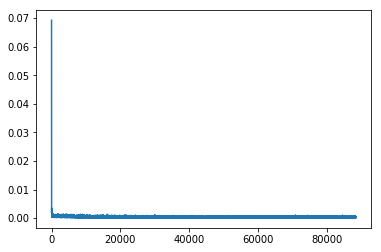

In [9]:
from matplotlib import pyplot as plt
plt.plot(loss_list)
plt.show()

In [10]:
# Guardamos el ultimo modelo
checkpoint_path_model = os.path.join('SINKP_NON_ETHUNIV_12_F', 'model.ckpt')
saver.save(sess,checkpoint_path_model , global_step = global_step)

'SINKP_NON_ETHUNIV_12_F/model.ckpt-88400'

# Restauramos los modelos

In [11]:
#Ultimo Modelo
path_model = 'SINKP_NON_ETHUNIV_12_F/model.ckpt-88400'
saver.restore(sess=sess, save_path=path_model)


test_data = batches_data.Dataset(data_prueba, arguments)
print('Evaluating')
results = evaluate(test_data, tester,sess,arguments)
print(results)

W0102 11:16:51.765767 140686521648896 deprecation.py:323] From /home/andrea/anaconda2/lib/python2.7/site-packages/tensorflow/python/training/saver.py:1276: checkpoint_exists (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use standard file APIs to check for files with this prefix.
 53%|#####2    | 9/17 [00:00<00:00, 86.35it/s]

Evaluating


100%|##########| 17/17 [00:00<00:00, 83.71it/s]

{'ade': 1.0788816, 'fde': 2.2212102}


In [13]:
#Modelo12
path_model = 'SINKP_NON_ETHUNIV_12/model.ckpt-88400'
saver.restore(sess=sess, save_path=path_model)


test_data = batches_data.Dataset(data_prueba, arguments)
print('Evaluating')
results = evaluate(test_data, tester,sess,arguments)
print(results)

 24%|##3       | 4/17 [00:00<00:00, 39.69it/s]

Evaluating


100%|##########| 17/17 [00:00<00:00, 46.32it/s]

{'ade': 1.0788816, 'fde': 2.2212102}


In [14]:
# Mejor Modelo
path_model = 'SINKP_NON_ETHUNIV-BEST_12/model_best.ckpt-67200'
saver.restore(sess=sess, save_path=path_model)

test_data = batches_data.Dataset(data_prueba, arguments)
print('Evaluating')
results = evaluate(test_data, tester,sess,arguments)
print(results)

 35%|###5      | 6/17 [00:00<00:00, 54.92it/s]

Evaluating


100%|##########| 17/17 [00:00<00:00, 63.97it/s]

{'ade': 1.0783424, 'fde': 2.2203975}
